In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/}kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
#file2 = file.sel(lat=slice(-24.6, -22), lon=slice(-42.3, -38.9))

wind=True

In [3]:
#wind
if wind:
  import xarray as xr
  import numpy as np
  import matplotlib.pyplot as plt
  from sklearn.preprocessing import StandardScaler
  from sklearn.preprocessing import MinMaxScaler

  #file=xr.open_dataset('dado_codar/codar_comp_pp.nc')  # estava sendo usado
#  file=xr.open_dataset('/kaggle/input/codar-res/codar_comp_8_cut.nc')
#  filem=xr.open_dataset('/kaggle/input/codar-res/merc_e.nc')
  file=xr.open_dataset('/kaggle/input/codar-res/codar_comp_9.nc')
  filem=xr.open_dataset('/kaggle/input/codar-res/merc_e2.nc')
  filem=filem.interp(latitude=file.lat.values, longitude=file.lon.values, time=file.time.values)
  uc=file.u.values
 # tt=np.where(np.isnan(uc))
 # uc[tt]=0
  vc=file.v.values
 # tt=np.where(np.isnan(vc))
 # vc[tt]=0    
  u=filem.uo.values[:,0,:]
  tt=np.where(np.isnan(u))
  u[tt]=0
  v=filem.vo.values[:,0,:]
  tt=np.where(np.isnan(v))
  v[tt]=0
  idx=np.load('/kaggle/input/codar-res/crl9.npy')
  mask = np.ones(len(u[:,0,0]), dtype=bool)
  mask[idx] = False    
  u=u[mask,:]
  v=v[mask,:]
  uc=uc[mask,:]
  vc=vc[mask,:] 
 # u=u[:-400,:]
 # v=v[:-400,:]
 # uc=uc[:-400,:]
 # vc=vc[:-400,:] 
  ucm=uc.copy()    
  u=u[:-2000,:]
  v=v[:-2000,:]
  uc=uc[:-2000,:]
  vc=vc[:-2000,:] 
  time = file.time.values[mask]  
  time=time[:-2000] 
  uo=u.copy()
  vo=v.copy()

In [4]:
filem.time[:-2000]

<xarray.DataArray 'time' (time: 25555)> Size: 204kB
array(['2021-10-21T22:00:00.000000000', '2021-10-21T23:00:00.000000209',
       '2021-10-22T00:00:00.000000419', ..., '2024-09-20T14:00:00.002677184',
       '2024-09-20T15:00:00.002677392', '2024-09-20T16:00:00.002677600'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 204kB 2021-10-21T22:00:00 ... 2024-09-20T1...
Attributes:
    standard_name:  time
    long_name:      Time
    axis:           T

In [5]:
filem.time[-2000:]

<xarray.DataArray 'time' (time: 2000)> Size: 16kB
array(['2024-09-20T17:00:00.002677600', '2024-09-20T18:00:00.002677600',
       '2024-09-20T19:00:00.002677808', ..., '2024-12-12T22:00:00.002886720',
       '2024-12-12T23:00:00.002886944', '2024-12-13T00:00:00.002887152'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 16kB 2024-09-20T17:00:00.002677600 ... 202...
Attributes:
    standard_name:  time
    long_name:      Time
    axis:           T

In [6]:
ucm=ucm[5000]*0
uc = uc + ucm
vc = vc + ucm

In [7]:
from scipy.ndimage import gaussian_filter1d
sigma=3



def filtrar_sem_buracos(array, sigma, axis=0):
    """Aplica um filtro passa-baixa gaussiano sem propagar NaNs."""
    array_filtrado = np.copy(array)
    
    # Iterar sobre todas as posições espaciais (lat, lon)
    for i in range(array.shape[1]):  # Dimensão lat
        for j in range(array.shape[2]):  # Dimensão lon
            serie = array[:, i, j]  # Extrai a série temporal
            
            # Se a série for toda NaN, pula
            if np.all(np.isnan(serie)):
                continue
            
            # Interpolação linear para preencher NaNs temporariamente
            mask = np.isnan(serie)
            if np.any(mask):  # Só interpola se houver NaNs
                serie[mask] = np.interp(
                    np.flatnonzero(mask),  # Índices onde há NaNs
                    np.flatnonzero(~mask),  # Índices onde NÃO há NaNs
                    serie[~mask]  # Valores conhecidos
                )
            
            # Aplicar filtro gaussiano
            serie_filtrada = gaussian_filter1d(serie, sigma=sigma, axis=0)
            
            # Restaurar NaNs onde estavam antes
            serie_filtrada[mask] = np.nan
            
            # Substituir na matriz final
            array_filtrado[:, i, j] = serie_filtrada

    return array_filtrado

import scipy.signal as signal

def filtrar_butterworth(array, cutoff=0.1, order=4, fs=1.0):
    """
    Aplica um filtro passa-baixa Butterworth ao longo da dimensão do tempo.
    
    Parâmetros:
    - array: numpy array com dimensões [tempo, lat, lon].
    - cutoff: frequência de corte normalizada (0 < cutoff < 0.5).
    - order: ordem do filtro (define a suavidade).
    - fs: frequência de amostragem (1.0 para dados horários).
    
    Retorna:
    - array filtrado.
    """
    array_filtrado = np.copy(array)
    
    # Criar filtro Butterworth
    b, a = signal.butter(order, cutoff, btype='low', fs=fs)
    
    # Aplicar o filtro ao longo da dimensão temporal
    for i in range(array.shape[1]):  # Dimensão lat
        for j in range(array.shape[2]):  # Dimensão lon
            serie = array[:, i, j]  # Extrai a série temporal

            if np.all(np.isnan(serie)):  # Se todos os valores forem NaN, pula
                continue

            # Interpolação para preencher NaNs temporariamente
            mask = np.isnan(serie)
            if np.any(mask):
                serie[mask] = np.interp(np.flatnonzero(mask), np.flatnonzero(~mask), serie[~mask])

            # Aplicar filtro Butterworth
            serie_filtrada = signal.filtfilt(b, a, serie)

            # Restaurar NaNs onde estavam antes
            serie_filtrada[mask] = np.nan

            # Substituir na matriz final
            array_filtrado[:, i, j] = serie_filtrada

    return array_filtrado

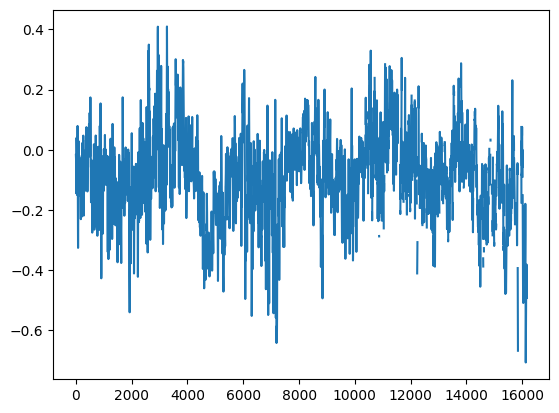

In [8]:
uc= filtrar_sem_buracos(uc, sigma=sigma)
vc= filtrar_sem_buracos(vc, sigma=sigma)
plt.plot(uc[:,20,20])


In [9]:
from sklearn.preprocessing import MinMaxScaler
input_scaleru = MinMaxScaler()
input_scalerv = MinMaxScaler()
input_scaleru.fit(u.reshape(-1,1))
input_scalerv.fit(v.reshape(-1,1))
u=input_scaleru.transform(u.reshape(-1,1)).reshape([u.shape[0], u.shape[1], u.shape[2]])
v=input_scalerv.transform(v.reshape(-1,1)).reshape([u.shape[0], u.shape[1], u.shape[2]])
u.shape
u[0,0,0]

0.33077419984328615

In [10]:
#u=input_scaleru.inverse_transform(u.reshape(-1,1)).reshape([u.shape[0], u.shape[1], u.shape[2]])
#u[0,0,0]
#u-uo
v.max()

1.0

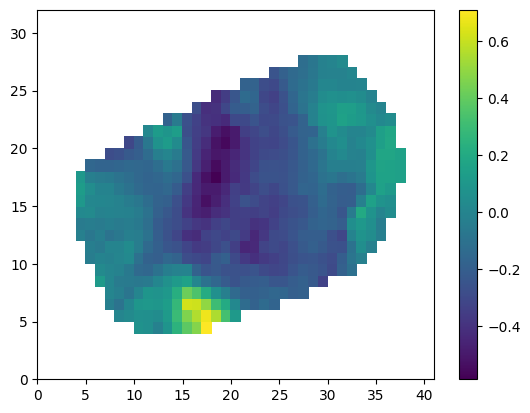

In [11]:
resu= uc -uo
resv= vc -vo

tt=np.where(np.isnan(resu))
resu[tt]=0
tt=np.where(np.isnan(resv))
resv[tt]=0 

input_scalerru = MinMaxScaler()
input_scalerrv = MinMaxScaler()
input_scalerru.fit(resu.reshape(-1,1))
input_scalerrv.fit(resv.reshape(-1,1))

resu=input_scalerru.transform(resu.reshape(-1,1)).reshape([u.shape[0], u.shape[1], u.shape[2]])
resv=input_scalerrv.transform(resv.reshape(-1,1)).reshape([u.shape[0], u.shape[1], u.shape[2]])

#resu= filtrar_sem_buracos(resu, sigma=sigma)
#resv= filtrar_sem_buracos(resv, sigma=sigma)

plt.pcolor(uc[-1]);plt.colorbar()
#resv[-1].min()


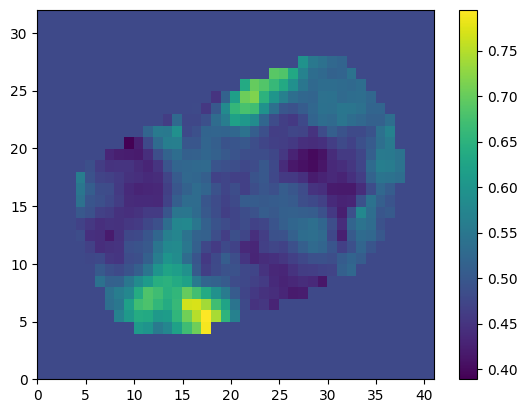

In [12]:
plt.pcolor(resu[-1]);plt.colorbar()


In [13]:
print(file.time.values[3])
file.time.values[0:3]
resu.min()

2021-10-22T01:00:00.000000419


0.0

In [14]:
av=3
data=u.copy()
input_seq_length = av * 1  # One month of hourly data
output_seq_length = 1  # Next 6 hours after the input month

input_sequencest = []
output_sequencest = []
#for i in range(len(data) - input_seq_length - output_seq_length + 1):
for i in range(len(data) - input_seq_length  + 1):
#for i in range(len(data) - input_seq_length ):
    input_seq = data[i : i + input_seq_length]
    output_seq = resu[i + input_seq_length-1]
    input_sequencest.append(input_seq)
    output_sequencest.append(output_seq)

input_sequencesu = np.array(input_sequencest)
output_sequencesu = np.array(output_sequencest)
print(input_sequencesu.shape)
print(output_sequencesu.shape)
len(data)-12


input_seq_length = av * 1  # One month of hourly data
data=v.copy()

# Initialize lists to store input and output sequences
input_sequencest = []
output_sequencest = []

# Create input and output sequences
for i in range(len(data) - input_seq_length +1):
    input_seq = data[i : i + input_seq_length]
    output_seq = resv[i + input_seq_length-1]
    input_sequencest.append(input_seq)
    output_sequencest.append(output_seq)

# Convert lists to numpy arrays
input_sequencesv = np.array(input_sequencest)
output_sequencesv = np.array(output_sequencest)
print(input_sequencesv.shape)
print(output_sequencesv.shape)
len(data)-12

(16162, 3, 32, 41)
(16162, 32, 41)
(16162, 3, 32, 41)
(16162, 32, 41)


16152

In [15]:
import matplotlib.pyplot as plt
import numpy as np
lon, lat = np.meshgrid(file.lon.values, file.lat.values)

#variable = lon * 31 + lat * 47
variable = lon * lat
#variable = np.sin(lon) + np.cos(lat)

input_scalervm = MinMaxScaler()

variable.reshape(-1,1).shape

input_scalervm.fit(variable.reshape(-1,1))

variablem=input_scalervm.transform(variable.reshape(-1,1)).reshape([variable.shape[0], variable.shape[1]])

input_sequencesv.shape

variable_expanded = np.repeat(variablem[np.newaxis, np.newaxis, :, :], input_sequencesv.shape[0], axis=0)  # Replicando para (16160, 1, 32, 41)
variable_expanded = np.repeat(variable_expanded, input_sequencesv.shape[1], axis=1)  # Replicando para (16160, 5, 32, 41)

1312
1312


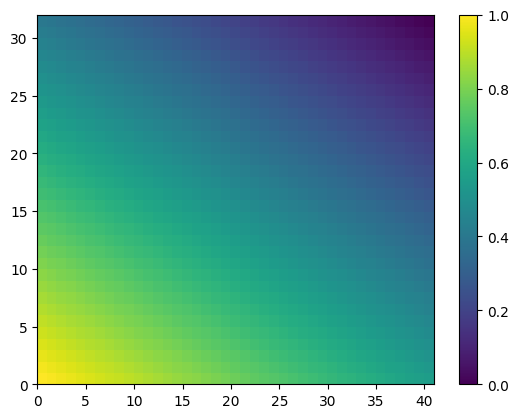

In [16]:
print(variable.shape[0]*variable.shape[1])
print(np.size(np.unique(variable)))
variable_expanded.shape
#variable_expanded
plt.pcolor(variable_expanded[-1,-1]);plt.colorbar()

In [17]:
input_sequences=np.zeros([input_sequencesv.shape[0], input_sequencesv.shape[1], input_sequencesv.shape[2], input_sequencesv.shape[3],2])
output_sequences=np.zeros([output_sequencesv.shape[0], output_sequencesv.shape[1], output_sequencesv.shape[2], 2])
#output_sequences=np.zeros([output_sequencesv.shape[0], output_sequencesv.shape[1], output_sequencesv.shape[2], 1])
input_sequences[:,:,:,:,0]=input_sequencesu
input_sequences[:,:,:,:,1]=input_sequencesv
#input_sequences[:,:,:,:,2]=variable_expanded
output_sequences[:,:,:,0]=output_sequencesu
#output_sequences[:,:,:,0]=output_sequencesv
output_sequences[:,:,:,1]=output_sequencesv

In [18]:
input_sequences.shape

(16162, 3, 32, 41, 2)

In [19]:
cut=8000 #default8000 dado codar_comp_8_cut
cut=12928
from sklearn.model_selection import train_test_split

train_data = input_sequences[0:cut]
train_target = output_sequences[0:cut]
test_data = input_sequences[cut:]
test_target = output_sequences[cut:]
#cut=18
#new_data = test_data[cut:]
#new_target = test_target[cut:]
#test_data = test_data[:cut]
#test_target = test_target[:cut]
#new_data2 = input_sequences[:1]
#new_target2 = output_sequences[:1]

train_data, test_data, train_target, test_target = train_test_split(
    input_sequences, output_sequences, test_size=0.2, shuffle=True, random_state=42
)


print(train_data.shape)
print(test_data.shape)
print(test_target.shape)
print(train_target.shape)


kk, input_seq_length,latitude_dim, longitude_dim, num_features=input_sequences.shape
output_seq_length=1
num_featureso=2
#num_featureso=1

kk,output_seq_length,input_seq_length, latitude_dim, longitude_dim, num_features, num_featureso
#print(train_target.shape)

(12929, 3, 32, 41, 2)
(3233, 3, 32, 41, 2)
(3233, 32, 41, 2)
(12929, 32, 41, 2)


(16162, 1, 3, 32, 41, 2, 2)

In [20]:
train_target.max()
test_target.max()

0.9867038917553994

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Reshape
from tensorflow.keras.callbacks import ModelCheckpoint
import numpy as np
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Conv3D, Conv2D,LSTM, Dense, Dropout, TimeDistributed, MaxPooling2D, ConvLSTM2D, BatchNormalization
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import MaxPooling3D, MaxPooling2D
from keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau


import numpy as np


model = Sequential()
#model.add(Conv3D(64, kernel_size=(3, 3, 3), activation='relu', input_shape=(input_seq_length, latitude_dim, longitude_dim, num_features)))
#model.add(TimeDistributed(Conv2D(32, kernel_size=(2,2), activation='relu', input_shape=(input_seq_length, latitude_dim, longitude_dim, num_features))))
#model.add(TimeDistributed(Conv2D(32, kernel_size=(2,2),  input_shape=(input_seq_length, latitude_dim, longitude_dim, num_features))))
##model.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))
#model.add(ConvLSTM2D(32, kernel_size=(2,2), activation='relu',  return_sequences=True,input_shape=(input_seq_length, latitude_dim, longitude_dim, num_features)))
#model.add(ConvLSTM2D(16, kernel_size=(2,2), activation='linear',  padding='same',  return_sequences=True,input_shape=(input_seq_length, latitude_dim, longitude_dim, num_features)))
model.add(ConvLSTM2D(16, kernel_size=(3,3), activation='relu',  padding='same',  return_sequences=True,input_shape=(input_seq_length, latitude_dim, longitude_dim, num_features)))
#model.add(ConvLSTM2D(16, kernel_size=(3,3),  padding='same', input_shape=(input_seq_length, latitude_dim, longitude_dim, num_features)))
#model.add(ConvLSTM2D(32, kernel_size=(3,3),  padding='same',input_shape=(input_seq_length, latitude_dim, longitude_dim, num_features)))
#model.add(ConvLSTM2D(32, kernel_size=(3,3),  padding='same', input_shape=(input_seq_length, latitude_dim, longitude_dim, num_features)))
model.add(BatchNormalization())

#model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(ConvLSTM2D(16, kernel_size=(3,3), activation='relu',  return_sequences=True))

model.add(BatchNormalization())

#model.add(Dropout(.3))

model.add(ConvLSTM2D(16, kernel_size=(2,2), activation='relu',  return_sequences=True))

#model.add(BatchNormalization())


#model.add(MaxPooling3D(pool_size=(2, 2, 2)))  # Pooling em (tempo, altura, largura)


#model.add(ConvLSTM2D(16, kernel_size=(2,2), activation='relu',  return_sequences=False))

#odel.add(TimeDistributed(Flatten()))  # to connect to LSTM without the need for any reshape https://machinelearningmastery.com/cnn-long-short-term-memory-networks/

#model.add(LSTM(units=32, return_sequences=True))
#model.add(Dropout(.3))

#model.add(LSTM(units=32, return_sequences=True))
#model.add(LSTM(units=32))
#model.add((Flatten()))

#model.add(LSTM(32, return_sequences=True))
model.add(Dropout(.3))
#model.add(LSTM(32))
model.add((Flatten()))  #precisa se o ultimo LSTM nao tiver return_sequences=True
#model.add(Dropout(.2))
#model.add(Dense(512, activation='linear'))
#model.add(Dropout(0.3))
#model.add(TimeDistributed(Dense(latitude_dim * longitude_dim * num_features, activation='linear')))
model.add(Dense(output_seq_length * latitude_dim * longitude_dim * num_featureso, activation='sigmoid'))

#model.add(Dense(output_seq_length * latitude_dim * longitude_dim * num_featureso))
#model.add(Dense(1024, activation='relu'))
#model.add(Dropout(.5))
#model.add(Reshape((output_seq_length, latitude_dim, longitude_dim, num_featureso)))
model.add(Reshape(( latitude_dim, longitude_dim, num_featureso)))


# Compile the model
#model.compile(loss='mean_squared_error', optimizer=Adam(learning_rate=1e-4))
model.compile(loss='mean_squared_error', optimizer='adam')
lr_scheduler = ReduceLROnPlateau(factor=0.5, patience=5, min_lr=1e-7)

#lr_scheduler = ReduceLROnPlateau(factor=0.5, patience=5, min_lr=1e-7, cooldown=10)   cooldown is the Learning Rate Drop Period


es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
#checkpoint = ModelCheckpoint(f'hfr_ml/convwind_12.h5', monitor='val_loss', save_best_only=True,  mode='min', verbose=1,patience=10)
checkpoint = ModelCheckpoint(f'convwind_res3ts.keras', monitor='val_loss', save_best_only=True,  mode='min', verbose=1)

# Train the model
history=model.fit(train_data, train_target,  validation_data=(test_data, test_target), epochs=150, batch_size=300, callbacks=[checkpoint, lr_scheduler, es])

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import ConvLSTM2D, Conv2D, BatchNormalization, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import numpy as np
import tensorflow as tf

model = Sequential()

# Camadas ConvLSTM2D
model.add(ConvLSTM2D(16, kernel_size=(3,3), activation='relu', padding='same',
                     return_sequences=True, input_shape=(input_seq_length, latitude_dim, longitude_dim, num_features)))
model.add(BatchNormalization())

model.add(ConvLSTM2D(16, kernel_size=(3,3), activation='relu', padding='same', return_sequences=True))
model.add(BatchNormalization())

model.add(ConvLSTM2D(16, kernel_size=(3,3), activation='relu', padding='same', return_sequences=False))  # <- último timestep
model.add(Dropout(0.3))

# Substituição da camada final:
model.add(Conv2D(num_featureso, kernel_size=(3,3), activation='sigmoid', padding='same'))  # <- substitui Dense + Reshape

# Compilação
model.compile(loss='mean_squared_error', optimizer='adam')

# Callbacks
lr_scheduler = ReduceLROnPlateau(factor=0.5, patience=5, min_lr=1e-7)
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
checkpoint = ModelCheckpoint('convwind_res3tscnn.keras', monitor='val_loss', save_best_only=True, mode='min', verbose=1)

# Train the model
history=model.fit(train_data, train_target,  validation_data=(test_data, test_target), epochs=150, batch_size=300, callbacks=[checkpoint, lr_scheduler, es])

In [21]:
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# Reshape para a regressão linear
train_data_reshaped = train_data.reshape(train_data.shape[0], -1)  # Achatar (16163, 2*32*41*2) -> (16163, 2*32*41*2)
train_target_reshaped = train_target.reshape(train_target.shape[0], -1)  # Achatar (16163, 32*41*2) -> (16163, 32*41*2)

# Criar e treinar o modelo de regressão linear
model = LinearRegression()

# Ajustar o modelo com os dados de treino
model.fit(train_data_reshaped, train_target_reshaped)

# Fazer previsões com os dados de teste


LinearRegression()

In [22]:
model

LinearRegression()

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Reshape
from tensorflow.keras.callbacks import ModelCheckpoint
import numpy as np
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Conv3D, Conv2D,LSTM, Dense, Dropout, TimeDistributed, MaxPooling2D, ConvLSTM2D, BatchNormalization
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import MaxPooling3D, MaxPooling2D
from keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau


import numpy as np

model = Sequential()

# Achatar a sequência temporal para a entrada
model.add(Flatten(input_shape=(input_seq_length, latitude_dim, longitude_dim, num_features)))

# Camada densa para realizar a regressão
model.add(Dense(latitude_dim * longitude_dim * num_featureso, activation='sigmoid'))

# Remodelar a saída de volta para (latitude_dim, longitude_dim, num_featureso)
model.add(Reshape((latitude_dim, longitude_dim, num_featureso)))

# Compilar o modelo
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mse'])

# Callbacks para ajuste do treinamento
lr_scheduler = ReduceLROnPlateau(factor=0.5, patience=5, min_lr=1e-7)
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
checkpoint = ModelCheckpoint('linear_regression_model.keras', monitor='val_loss', save_best_only=True, mode='min', verbose=1)

# Treinar o modelo
history = model.fit(
    train_data, train_target, 
    validation_data=(test_data, test_target), 
    epochs=200, batch_size=200, 
    callbacks=[checkpoint, lr_scheduler, es]
)

In [ ]:
# 📌 Função de perda RMSE considerando a máscara do input (-999)
def masked_rmse_loss(y_true, y_pred, X_input):
    """
    Calcula o RMSE apenas para os pontos onde X_input é válido (diferente de -999).
    
    Parâmetros:
    - y_true: Valores reais do target (saída esperada).
    - y_pred: Valores previstos pelo modelo.
    - X_input: Entrada usada para mascarar regiões inválidas.
    
    Retorna:
    - RMSE considerando apenas os pontos válidos.
    """
    # Criar uma máscara onde X_input é diferente de -999
    mask = tf.cast(tf.not_equal(X_input, -999.0), tf.float32)

    # Substituir os valores de y_true e y_pred para 0 onde a máscara é 0 (ignorar no cálculo)
    y_true_masked = tf.where(tf.equal(mask, 0), tf.zeros_like(y_true), y_true)
    y_pred_masked = tf.where(tf.equal(mask, 0), tf.zeros_like(y_pred), y_pred)

    # Calcular o erro quadrático apenas onde X_input é válido
    squared_error = tf.square(y_true_masked - y_pred_masked)

    # Média dos erros apenas nos pontos válidos (evitando divisão por zero com um epsilon)
    mse = tf.reduce_sum(squared_error) / (tf.reduce_sum(mask) + tf.keras.backend.epsilon())

    # Retornar RMSE
    return tf.sqrt(mse)

# 📌 Classe personalizada para passar X_input na perda
class MaskedRMSELoss(tf.keras.losses.Loss):
    def __init__(self, X_input):
        super().__init__()
        self.X_input = X_input  # Armazena o input com os valores -999

    def call(self, y_true, y_pred):
        return masked_rmse_loss(y_true, y_pred, self.X_input)

# 🔹 Definição do modelo ConvLSTM2D
model = Sequential()
model.add(ConvLSTM2D(16, kernel_size=(3,3), activation='relu', padding='same', return_sequences=True,
                     input_shape=(input_seq_length, latitude_dim, longitude_dim, num_features)))
model.add(BatchNormalization())

model.add(ConvLSTM2D(16, kernel_size=(3,3), activation='relu', return_sequences=True))
model.add(BatchNormalization())

model.add(ConvLSTM2D(16, kernel_size=(2,2), activation='relu', return_sequences=True))

model.add(Dropout(0.3))
model.add(Flatten())
model.add(Dense(output_seq_length * latitude_dim * longitude_dim * num_featureso, activation='sigmoid'))
model.add(Reshape((latitude_dim, longitude_dim, num_featureso)))

# 🔹 Criar um exemplo de entrada com -999 (substituir pelo dataset real)
X_input_with_mask = train_data  # Substitua isso pelos seus dados reais

# Criar o objeto de função de perda customizada
custom_loss = MaskedRMSELoss(X_input_with_mask)

# 🔹 Compilar o modelo com a função de perda customizada
model.compile(loss=custom_loss, optimizer='adam')

# 🔹 Configuração dos callbacks
lr_scheduler = ReduceLROnPlateau(factor=0.5, patience=5, min_lr=1e-7)
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
checkpoint = ModelCheckpoint('convwind_res.keras', monitor='val_loss', save_best_only=True, mode='min', verbose=1)

# 🔹 Treinamento do modelo
history = model.fit(train_data, train_target,
                    validation_data=(test_data, test_target),
                    epochs=120,
                    batch_size=200,
                    callbacks=[checkpoint, lr_scheduler, es])

In [ ]:
def plot_training_history(history1,  model_names=['Box to Minibox']):
    plt.figure(figsize=(12, 5))
    
    # Plot da Loss de Treino
    plt.subplot(1, 2, 1)
    plt.plot(history1.history['loss'], label=f'{model_names[0]} - Treino')
    plt.title('Loss de Treino')
    plt.ylabel('MSE')
    plt.xlabel('Época')
    plt.legend()
    plt.grid(True)
    
    # Plot da Loss de Validação
    plt.subplot(1, 2, 2)
    plt.plot(history1.history['val_loss'], label=f'{model_names[0]} - Validação')
    plt.title('Loss de Validação')
    plt.ylabel('MSE')
    plt.xlabel('Época')
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()

# Uso (ajuste os nomes das variáveis conforme seu código):
plot_training_history(history)

In [106]:
#wind
if wind:
  import xarray as xr
  import numpy as np
  import matplotlib.pyplot as plt
  from sklearn.preprocessing import StandardScaler
  from sklearn.preprocessing import MinMaxScaler

  #file=xr.open_dataset('dado_codar/codar_comp_pp.nc')  # estava sendo usado
  file=xr.open_dataset('/kaggle/input/codar-res/codar_comp_9.nc')
  filem=xr.open_dataset('/kaggle/input/codar-res/merc_e2.nc')
#  filecodar=xr.open_dataset('/kaggle/input/codar-res/oscar_current.nc')
#  file=xr.open_dataset('/kaggle/input/codar-res/codar_comp_8_cut.nc')
#  filem=xr.open_dataset('/kaggle/input/codar-res/merc_e2.nc')    
  filem=filem.interp(latitude=file.lat.values, longitude=file.lon.values, time=file.time.values)
  uc=file.u.values
 # tt=np.where(np.isnan(uc))
 # uc[tt]=0
  vc=file.v.values
 # tt=np.where(np.isnan(vc))
 # vc[tt]=0    
  u=filem.uo.values[:,0,:]
  tt=np.where(np.isnan(u))
  u[tt]=0
  v=filem.vo.values[:,0,:]
  tt=np.where(np.isnan(v))
  v[tt]=0
  idx=np.load('/kaggle/input/codar-res/crl9.npy')
  mask = np.ones(len(u[:,0,0]), dtype=bool)
  mask[idx] = False    
  u=u[mask,:]
  v=v[mask,:]
  uc=uc[mask,:]
  vc=vc[mask,:] 
#  a=-15000
  ucm=uc.copy()
  a=-2000 
  b=-1    
  u=u[a:b,:]
  v=v[a:b,:]
  uc=uc[a:b,:]
  vc=vc[a:b,:] 

In [107]:
pip install cftime


Note: you may need to restart the kernel to use updated packages.


In [108]:
print(filecodar)

<xarray.Dataset> Size: 1GB
Dimensions:  (time: 27555, lat: 32, lon: 41)
Coordinates:
  * lat      (lat) float64 256B -24.6 -24.52 -24.43 ... -22.18 -22.1 -22.02
  * lon      (lon) float64 328B -42.3 -42.22 -42.13 ... -39.13 -39.05 -38.97
  * time     (time) datetime64[ns] 220kB 2021-10-21T22:00:00 ... 2024-12-13T0...
Data variables:
    u        (time, lat, lon) float64 289MB nan nan nan ... -0.1706 -0.1525
    v        (time, lat, lon) float64 289MB nan nan nan ... -0.078 -0.1076
    ug       (time, lat, lon) float64 289MB nan nan nan ... -0.1245 -0.1059
    vg       (time, lat, lon) float64 289MB nan nan nan ... -0.04313 -0.07356
Attributes: (12/36)
    title:                      Ocean Surface Current Analyses Real-time (OSC...
    summary:                    Global, daily, 0.25 degree geostrophic and to...
    keywords:                   ocean currents,ocean circulation,surface curr...
    Conventions:                CF-1.8 Standard Names v77, ACDD-1.3, netcdf 4...
    id:         

In [109]:
filecodar=xr.open_dataset('/kaggle/input/codar-res/oscar_current.nc')

import datetime

times_datetime = np.array([
    datetime.datetime(t.year, t.month, t.day, t.hour, t.minute, t.second)
    for t in filecodar['time'].values
])

filecodar['time'] = times_datetime


filecodar=filecodar.interp(lat=file.lat.values, lon=file.lon.values, time=file.time.values)

#print(filecodar.time)  # Em vez de só colocar "filecodar"



In [110]:
#ucm=ucm[5000]*0
#plt.pcolor(ucm);plt.colorbar()
#ucm.shape
#uc.shape
#plt.pcolor(uc_result[0])
#plt.pcolor(uc[-1])

In [111]:
ucm=ucm[5000]*0
uc = uc + ucm
vc = vc + ucm


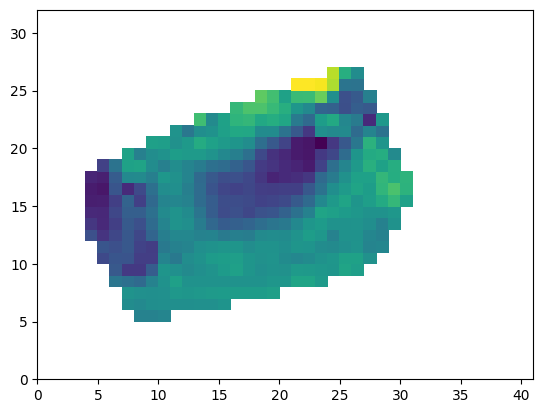

In [112]:
plt.pcolor(vc[-1])

In [113]:
uc= filtrar_sem_buracos(uc, sigma=sigma)
vc= filtrar_sem_buracos(vc, sigma=sigma)

In [114]:
vf=v.copy()
u=input_scaleru.transform(u.reshape(-1,1)).reshape([u.shape[0], u.shape[1], u.shape[2]])
v=input_scalerv.transform(v.reshape(-1,1)).reshape([u.shape[0], u.shape[1], u.shape[2]])


In [115]:
av=3
data=u.copy()
input_seq_length = av * 1  # One month of hourly data
output_seq_length = 1  # Next 6 hours after the input month

input_sequencest = []
output_sequencest = []
#for i in range(len(data) - input_seq_length - output_seq_length + 1):
for i in range(len(data) - input_seq_length  + 1):
#for i in range(len(data) - input_seq_length ):
    input_seq = data[i : i + input_seq_length]
    output_seq = uc[i + input_seq_length-1]
    input_sequencest.append(input_seq)
    output_sequencest.append(output_seq)

input_sequencesu = np.array(input_sequencest)
output_sequencesu = np.array(output_sequencest)
print(input_sequencesu.shape)
print(output_sequencesu.shape)
len(data)-12

input_seq_length = av * 1  # One month of hourly data
data=v.copy()
#data=vf.copy()

# Initialize lists to store input and output sequences
input_sequencest = []
output_sequencest = []

# Create input and output sequences
for i in range(len(data) - input_seq_length +1):
    input_seq = data[i : i + input_seq_length]
    output_seq = vc[i + input_seq_length-1]
    input_sequencest.append(input_seq)
    output_sequencest.append(output_seq)

# Convert lists to numpy arrays
input_sequencesv = np.array(input_sequencest)
output_sequencesv = np.array(output_sequencest)
print(input_sequencesv.shape)
print(output_sequencesv.shape)
len(data)-12


variable_expanded = np.repeat(variablem[np.newaxis, np.newaxis, :, :], input_sequencesv.shape[0], axis=0)  # Replicando para (16160, 1, 32, 41)
variable_expanded = np.repeat(variable_expanded, input_sequencesv.shape[1], axis=1)  # Replicando para (16160, 5, 32, 41)


input_sequences=np.zeros([input_sequencesv.shape[0], input_sequencesv.shape[1], input_sequencesv.shape[2], input_sequencesv.shape[3],2])
output_sequences=np.zeros([output_sequencesv.shape[0], output_sequencesv.shape[1], output_sequencesv.shape[2], 2])

input_sequences[:,:,:,:,0]=input_sequencesu
input_sequences[:,:,:,:,1]=input_sequencesv
#input_sequences[:,:,:,:,2]=variable_expanded
output_sequences[:,:,:,0]=output_sequencesu
output_sequences[:,:,:,1]=output_sequencesv

(1997, 3, 32, 41)
(1997, 32, 41)
(1997, 3, 32, 41)
(1997, 32, 41)


In [116]:
input_sequencesv.max()
input_sequences.shape

(1997, 3, 32, 41, 2)

In [117]:
from keras.models import load_model
#best_model = load_model("/kaggle/working/convwind_res3ts.keras")
best_model = load_model("/kaggle/input/codar-res/convwind_res3ts.keras")

#best_model = load_model("/kaggle/working/linear_regression_model.keras")

predicted_res = best_model.predict(input_sequences)


63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step


In [118]:
predicted_resl = model.predict(input_sequences.reshape(input_sequences.shape[0], -1))
predicted_resl = predicted_resl.reshape(output_sequences.shape)
predicted_resl.shape

(1997, 32, 41, 2)

In [119]:
print(predicted_res.shape)
print(input_sequences.shape)
#predicted_res
#predicted_res[:,:,:,-1]
#vs
input_sequences.shape

(1997, 32, 41, 2)
(1997, 3, 32, 41, 2)


(1997, 3, 32, 41, 2)

In [120]:
vi=input_sequences[:,-1,:,:,1].copy()

vi=input_scalerv.inverse_transform(vi.reshape(-1,1)).reshape([vi.shape[0],vi.shape[1], vi.shape[2]])

vit=vi.copy()

vs=predicted_res[:,:,:,-1].copy()
vs=input_scalerrv.inverse_transform(vs.reshape(-1,1)).reshape([vi.shape[0],vi.shape[1], vi.shape[2]])

vsl=predicted_resl[:,:,:,-1].copy()
vsl=input_scalerrv.inverse_transform(vsl.reshape(-1,1)).reshape([vi.shape[0],vi.shape[1], vi.shape[2]])


ui=input_sequences[:,-1,:,:,0]

ui=input_scaleru.inverse_transform(ui.reshape(-1,1)).reshape([vi.shape[0],vi.shape[1], vi.shape[2]])

us=predicted_res[:,:,:,0]
us=input_scalerru.inverse_transform(us.reshape(-1,1)).reshape([vi.shape[0],vi.shape[1], vi.shape[2]])


usl=predicted_resl[:,:,:,0]
usl=input_scalerru.inverse_transform(usl.reshape(-1,1)).reshape([vi.shape[0],vi.shape[1], vi.shape[2]])

        

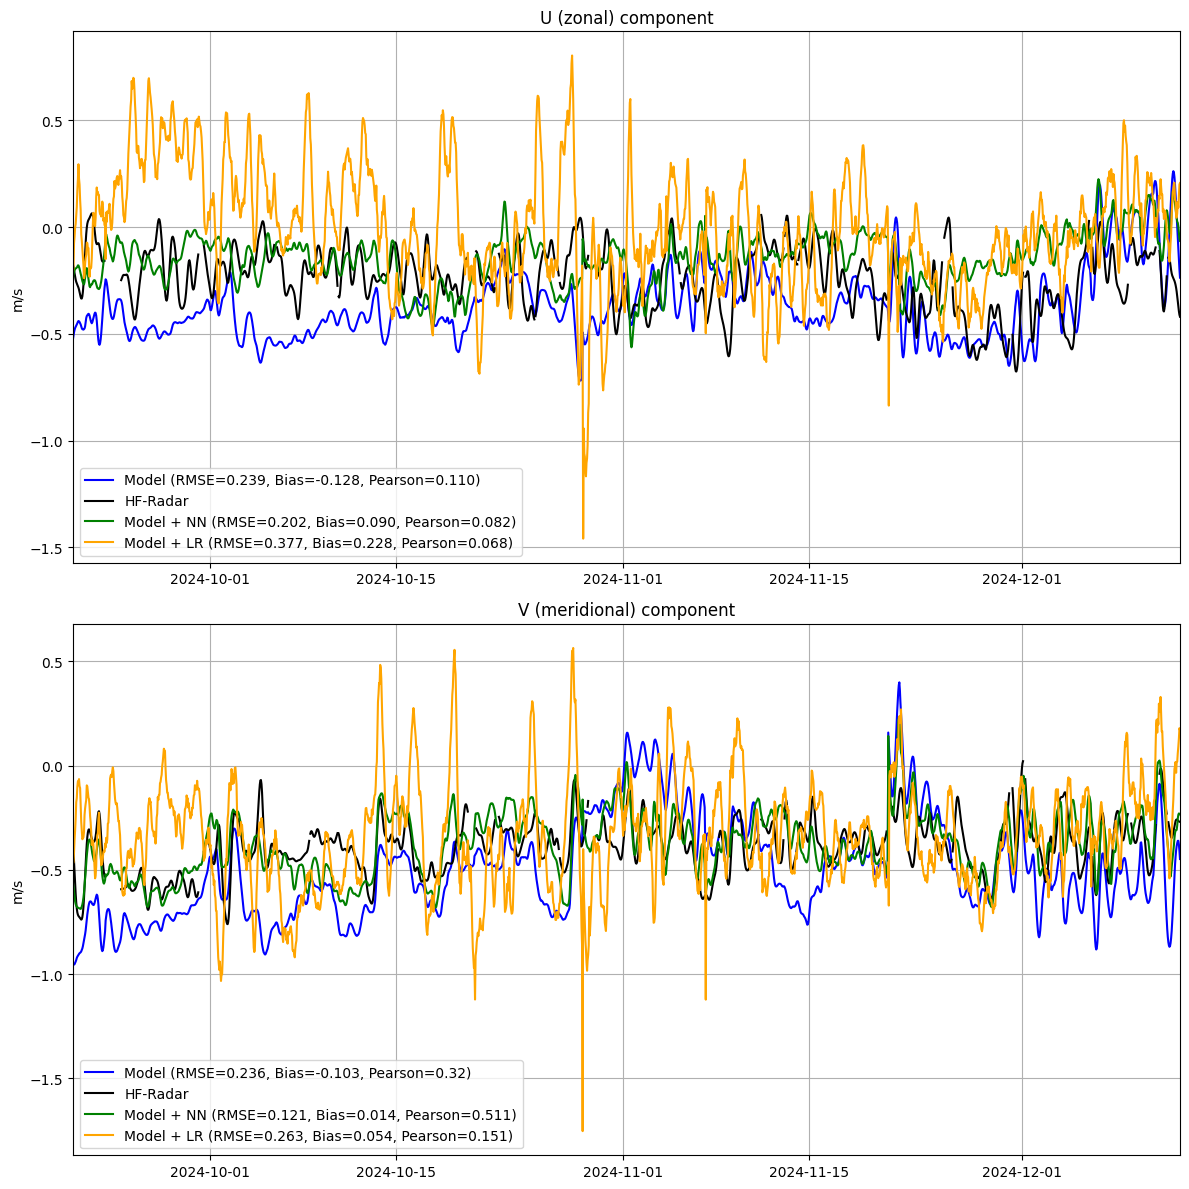

In [121]:
import numpy as np
import matplotlib.pyplot as plt

# Coordenadas do ponto (latitude=10, longitude=20)
lat_idx=13     #13     13    22 
lon_idx=14     #24     14    24

# Cálculo e plots para U
model_u = ui[:, lat_idx, lon_idx]
measured_u = output_sequences[:, lat_idx, lon_idx, 0]
corrected_u = (ui + us)[:, lat_idx, lon_idx]
corrected_ul = (ui + usl)[:, lat_idx, lon_idx]

rmse_original_u = np.sqrt(np.nanmean((model_u - measured_u) ** 2))
bias_original_u = np.nanmean(model_u - measured_u)
rmse_corrected_u = np.sqrt(np.nanmean((corrected_u - measured_u) ** 2))
bias_corrected_u = np.nanmean(corrected_u - measured_u)
rmse_corrected_ul = np.sqrt(np.nanmean((corrected_ul - measured_u) ** 2))
bias_corrected_ul = np.nanmean(corrected_ul - measured_u)



# Cálculo e plots para V
model_v = vi[:, lat_idx, lon_idx]
measured_v = output_sequences[:, lat_idx, lon_idx, -1]
corrected_v = (vi + vs)[:, lat_idx, lon_idx]
corrected_vl = (vi + vsl)[:, lat_idx, lon_idx]

rmse_original_v = np.sqrt(np.nanmean((model_v - measured_v) ** 2))
bias_original_v = np.nanmean(model_v - measured_v)
rmse_corrected_v = np.sqrt(np.nanmean((corrected_v - measured_v) ** 2))
bias_corrected_v = np.nanmean(corrected_v - measured_v)

rmse_corrected_vl = np.sqrt(np.nanmean((corrected_vl- measured_v) ** 2))
bias_corrected_vl = np.nanmean(corrected_vl - measured_v)


pearson_original_u = np.corrcoef(np.nan_to_num(model_u), np.nan_to_num(measured_u))[0, 1]
pearson_corrected_u = np.corrcoef(np.nan_to_num(corrected_u), np.nan_to_num(measured_u))[0, 1]
pearson_corrected_ul = np.corrcoef(np.nan_to_num(corrected_ul), np.nan_to_num(measured_u))[0, 1]

#If still have a problem, add an extra verification.
if np.isnan(pearson_original_u):
    pearson_original_u = 0.0  # Or another appropriate default value
if np.isnan(pearson_corrected_u):
    pearson_corrected_u = 0.0
if np.isnan(pearson_corrected_ul):
    pearson_corrected_ul = 0.0

pearson_original_v = np.corrcoef(np.nan_to_num(model_v), np.nan_to_num(measured_v))[0, 1]
pearson_corrected_v = np.corrcoef(np.nan_to_num(corrected_v), np.nan_to_num(measured_v))[0, 1]
pearson_corrected_vl = np.corrcoef(np.nan_to_num(corrected_vl), np.nan_to_num(measured_v))[0, 1]

if np.isnan(pearson_original_v):
    pearson_original_v = 0.0
if np.isnan(pearson_corrected_v):
    pearson_corrected_v = 0.0
if np.isnan(pearson_corrected_vl):
    pearson_corrected_vl = 0.0

# Plot
idx=-3
fig, axs = plt.subplots(2, 1, figsize=(12, 12))

# Subplot A para U
axs[0].plot(filem.time[a:idx],model_u, label=f"Model (RMSE={rmse_original_u:.3f}, Bias={bias_original_u:.3f}, Pearson={pearson_original_u:.3f})", color='blue')
axs[0].plot(filem.time[a:idx],measured_u, label="HF-Radar", color='black')
axs[0].plot(filem.time[a:idx],corrected_u, label=f"Model + NN (RMSE={rmse_corrected_u:.3f}, Bias={bias_corrected_u:.3f}, Pearson={pearson_corrected_u:.3f})", color='green')
axs[0].plot(filem.time[a:idx],corrected_ul, label=f"Model + LR (RMSE={rmse_corrected_ul:.3f}, Bias={bias_corrected_ul:.3f}, Pearson={pearson_corrected_ul:.3f})", color='orange')
axs[0].set_xlim([filem.time[a:idx].min(), filem.time[a:idx].max()])
axs[0].set_title("U (zonal) component")
#axs[0].set_xlabel("time")
axs[0].set_ylabel("m/s")
axs[0].legend()
axs[0].grid()

# Subplot B para V
axs[1].plot(filem.time[a:idx],model_v, label=f"Model (RMSE={rmse_original_v:.3f}, Bias={bias_original_v:.3f}, Pearson={pearson_original_v:.2f})", color='blue')
axs[1].plot(filem.time[a:idx],measured_v, label="HF-Radar", color='black')
axs[1].plot(filem.time[a:idx],corrected_v, label=f"Model + NN (RMSE={rmse_corrected_v:.3f}, Bias={bias_corrected_v:.3f}, Pearson={pearson_corrected_v:.3f})", color='green')
axs[1].plot(filem.time[a:idx],corrected_vl, label=f"Model + LR (RMSE={rmse_corrected_vl:.3f}, Bias={bias_corrected_vl:.3f}, Pearson={pearson_corrected_vl:.3f})", color='orange')
axs[1].set_title("V (meridional) component")
axs[1].set_xlim([filem.time[a:idx].min(), filem.time[a:idx].max()])
#axs[1].set_xlabel("Tempo")
axs[1].set_ylabel("m/s")
axs[1].legend()
axs[1].grid()

plt.tight_layout()
plt.savefig('velocity'+str(lat_idx)+str(lon_idx)+'1ts'+'.png',dpi=200, transparent=False, bbox_inches="tight")

plt.show()

In [122]:
import numpy as np
import pandas as pd

# Função para calcular métricas e melhorias
def calc_metrics(ui, vi, us, vs, usl, vsl, output_sequences, lat_idx, lon_idx):
    metrics = {}

    # U component
    model_u = ui[:, lat_idx, lon_idx]
    measured_u = output_sequences[:, lat_idx, lon_idx, 0]
    corrected_u = (ui + us)[:, lat_idx, lon_idx]
    corrected_ul = (ui + usl)[:, lat_idx, lon_idx]

    # V component
    model_v = vi[:, lat_idx, lon_idx]
    measured_v = output_sequences[:, lat_idx, lon_idx, -1]
    corrected_v = (vi + vs)[:, lat_idx, lon_idx]
    corrected_vl = (vi + vsl)[:, lat_idx, lon_idx]

    # Helper function
    def stats(model, measured, corrected, corrected_l):
        rmse_m = np.sqrt(np.nanmean((model - measured) ** 2))
        bias_m = np.nanmean(model - measured)
        pearson_m = np.corrcoef(np.nan_to_num(model), np.nan_to_num(measured))[0, 1]

        rmse_c = np.sqrt(np.nanmean((corrected - measured) ** 2))
        bias_c = np.nanmean(corrected - measured)
        pearson_c = np.corrcoef(np.nan_to_num(corrected), np.nan_to_num(measured))[0, 1]

        rmse_cl = np.sqrt(np.nanmean((corrected_l - measured) ** 2))
        bias_cl = np.nanmean(corrected_l - measured)
        pearson_cl = np.corrcoef(np.nan_to_num(corrected_l), np.nan_to_num(measured))[0, 1]

        return {
            'rmse_m': rmse_m, 'bias_m': bias_m, 'pearson_m': pearson_m,
            'rmse_c': rmse_c, 'bias_c': bias_c, 'pearson_c': pearson_c,
            'rmse_cl': rmse_cl, 'bias_cl': bias_cl, 'pearson_cl': pearson_cl
        }

    metrics['U'] = stats(model_u, measured_u, corrected_u, corrected_ul)
    metrics['V'] = stats(model_v, measured_v, corrected_v, corrected_vl)

    return metrics

# Índices dos três pontos
points = {'P1': (22, 24), 'P2': (13, 14), 'P3': (13, 24)}

# Armazenar resultados
results = []

for pname, (lat_idx, lon_idx) in points.items():
    metrics = calc_metrics(ui, vi, us, vs, usl, vsl, output_sequences, lat_idx, lon_idx)
    for comp in ['U', 'V']:
        m = metrics[comp]
        # Melhoria percentual
        rmse_imp_nn = 100 * (m['rmse_m'] - m['rmse_c']) / m['rmse_m']
        rmse_imp_lr = 100 * (m['rmse_m'] - m['rmse_cl']) / m['rmse_m']
        
        bias_imp_nn = 100 * (abs(m['bias_m']) - abs(m['bias_c'])) / abs(m['bias_m']) if m['bias_m'] != 0 else 0
        bias_imp_lr = 100 * (abs(m['bias_m']) - abs(m['bias_cl'])) / abs(m['bias_m']) if m['bias_m'] != 0 else 0

        pearson_imp_nn = 100 * (m['pearson_c'] - m['pearson_m']) / abs(m['pearson_m']) if m['pearson_m'] != 0 else 0
        pearson_imp_lr = 100 * (m['pearson_cl'] - m['pearson_m']) / abs(m['pearson_m']) if m['pearson_m'] != 0 else 0
        
        results.append({
            'Point': pname,
            'Component': comp,
            'RMSE Model': round(m['rmse_m'], 3),
            'RMSE + NN': round(m['rmse_c'], 3),
            'RMSE + LR': round(m['rmse_cl'], 3),
            'Bias Model': round(m['bias_m'], 3),
            'Bias + NN': round(m['bias_c'], 3),
            'Bias + LR': round(m['bias_cl'], 3),
            'Pearson Model': round(m['pearson_m'], 3),
            'Pearson + NN': round(m['pearson_c'], 3),
            'Pearson + LR': round(m['pearson_cl'], 3),
            'RMSE Improvement NN (%)': round(rmse_imp_nn, 1),
            'RMSE Improvement LR (%)': round(rmse_imp_lr, 1),
            'Bias Improvement NN (%)': round(bias_imp_nn, 1),
            'Bias Improvement LR (%)': round(bias_imp_lr, 1),
            'Pearson Improvement NN (%)': round(pearson_imp_nn, 1),
            'Pearson Improvement LR (%)': round(pearson_imp_lr, 1)
        })

# Criar DataFrame
df = pd.DataFrame(results)

# Mostrar a tabela
print(df.to_string(index=False))

df.to_excel('metrics_summary.xlsx', index=False)
# Opcional: salvar em CSV ou LaTeX
# df.to_csv('metrics_summary.csv', index=False)
# print(df.to_latex(index=False))

Point Component  RMSE Model  RMSE + NN  RMSE + LR  Bias Model  Bias + NN  Bias + LR  Pearson Model  Pearson + NN  Pearson + LR  RMSE Improvement NN (%)  RMSE Improvement LR (%)  Bias Improvement NN (%)  Bias Improvement LR (%)  Pearson Improvement NN (%)  Pearson Improvement LR (%)
   P1         U       0.360      0.171      0.374      -0.225      0.052      0.171          0.181         0.244         0.002                     52.6                     -3.8                     76.7                     24.2                        35.0                       -98.9
   P1         V       0.356      0.274      0.423      -0.121      0.012      0.034          0.414         0.439         0.109                     23.0                    -18.7                     90.2                     72.2                         6.1                       -73.7
   P2         U       0.239      0.202      0.377      -0.128      0.090      0.228          0.110         0.082         0.068                     15.4

In [123]:
pip install matplotlib-scalebar

Note: you may need to restart the kernel to use updated packages.


22 24


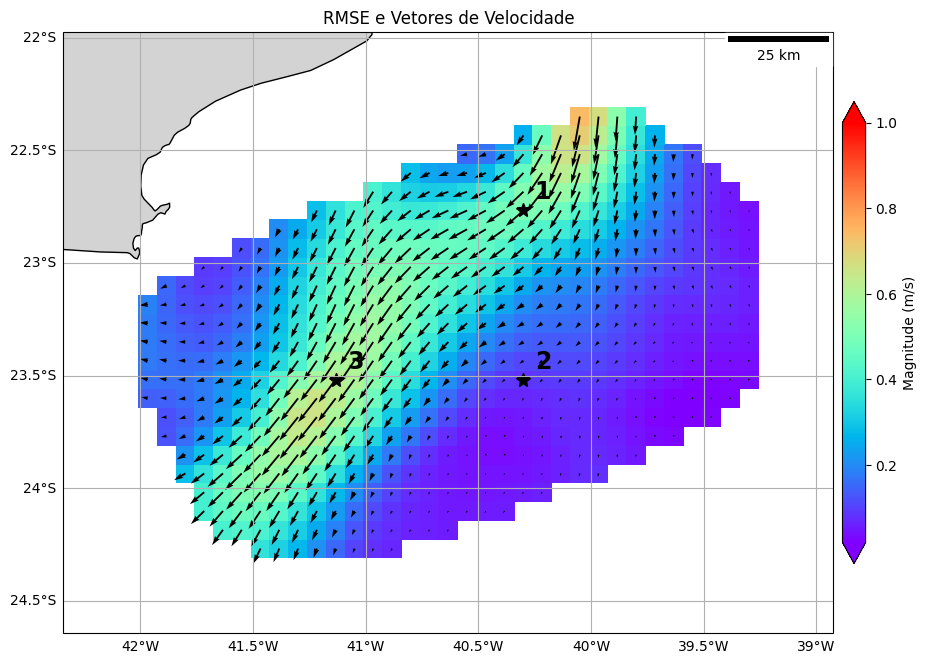

(1999, 32, 41)

In [124]:
lon, lat = np.meshgrid(file.lon.values, file.lat.values)

lat_idx=22     #13     13    22 
lon_idx=24     #24     14    24

print(lat_idx, lon_idx)


import matplotlib.pyplot as plt
import numpy as np

# Calculando a raiz quadrada do erro quadrático médio (RMSE)
rmse = np.sqrt(
    (np.nanmean(ui, axis=0) - uc[0] * 0)**2 + (np.nanmean(vi, axis=0) - uc[0] * 0)**2
)

# Criando o gráfico
import cartopy.crs as ccrs
import cartopy.feature as cfeature

from matplotlib_scalebar.scalebar import ScaleBar
from geopy.distance import geodesic

# Criando o gráfico com projeção Cartopy
fig, ax = plt.subplots(figsize=(10, 8), subplot_kw={'projection': ccrs.PlateCarree()})

# Plotando o RMSE usando pcolor com a colormap 'viridis'
pc = ax.pcolor(lon, lat, ((np.nanmean(ui, axis=0) - uc[0] * 0)**2 +  (np.nanmean(vi, axis=0) - uc[0] * 0)**2)**(1/2), vmax=1,cmap='rainbow')

# Adicionando o ponto específico de interesse (lat_idx, lon_idx) com estrela branca

lat_idx=22     #13     13    22 
lon_idx=24     #24     14    24

ax.plot(lon[lat_idx, lon_idx], lat[lat_idx, lon_idx], "*", color='black', markersize=10)
ax.text(
    lon[lat_idx, lon_idx]+0.05, lat[lat_idx, lon_idx]+0.05, "1", color='black', fontsize=17, weight='bold'
)

lat_idx=13     #13     13    22 
lon_idx=24     #24     14    24

ax.plot(lon[lat_idx, lon_idx], lat[lat_idx, lon_idx], "*", color='black', markersize=10)
ax.text(
    lon[lat_idx, lon_idx]+0.05, lat[lat_idx, lon_idx]+0.05, "2", color='black', fontsize=17, weight='bold'
)
lat_idx=13     #13     13    22 
lon_idx=14     #24     14    24

ax.plot(lon[lat_idx, lon_idx], lat[lat_idx, lon_idx], "*", color='black', markersize=10)
ax.text(
    lon[lat_idx, lon_idx]+0.05, lat[lat_idx, lon_idx]+0.05, "3", color='black', fontsize=17, weight='bold'
)

# Adicionando as setas do quiver (vetores de velocidade)
q = ax.quiver(lon, lat, np.mean(ui, axis=0) - uc[0] * 0, np.mean(vi, axis=0) - uc[0] * 0)




# Adicionando o colorbar para o RMSE
cbar = fig.colorbar(pc, ax=ax, orientation='vertical', pad=0.01, shrink=0.6, extend='both')  # O valor de shrink ajusta o tamanho
cbar.set_label("Magnitude (m/s)")

# Ajustando os eixos e a legenda
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.set_title("RMSE e Vetores de Velocidade")

# Exibindo a grade
ax.coastlines()
ax.add_feature(cfeature.BORDERS, linewidth=0.5)
ax.add_feature(cfeature.LAND, facecolor='lightgray')
ax.add_feature(cfeature.OCEAN, facecolor='white')

# Ajustando eixos e título
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
#ax.set_title("RMSE e Vetores de Velocidade")

# Grade com rótulos
gl = ax.gridlines(draw_labels=True)
gl.linewidth = 0.2  # ou outro valor menor que 1 para linhas mais finas
gl.top_labels = False    # Remove os rótulos do topo
gl.right_labels = False  # Remove os rótulos da direita# Exibindo o gráfico
plt.tight_layout()
dx = geodesic((-39.5, -22.5), (-39, -22.5)).km
scalebar = ScaleBar(dx, "km")
ax.add_artist(scalebar)

plt.show()


#plt.pcolor(lon, lat, ((np.nanmean(ui, axis=0) - uc[0] * 0)**2 +  (np.nanmean(vi, axis=0) - uc[0] * 0)**2)**(1/2), cmap='viridis')
#plt.plot(lon[lat_idx, lon_idx], lat[lat_idx, lon_idx], "*", color='white')
#plt.quiver(lon, lat, np.mean(ui, axis=0) - uc[0] * 0, np.mean(vi, axis=0) - uc[0] * 0)

#cax = plt.axes([0.38, 0.02, 0.25, 0.03])  # Aqui, você pode ajustar a posição (esquerda, embaixo, largura, altura)
#cbar = plt.colorbar(pc1, cax=cax, orientation='horizontal')
#cbar = plt.colorbar()
#cbar.set_label("RMSE")



vc.shape

22 24


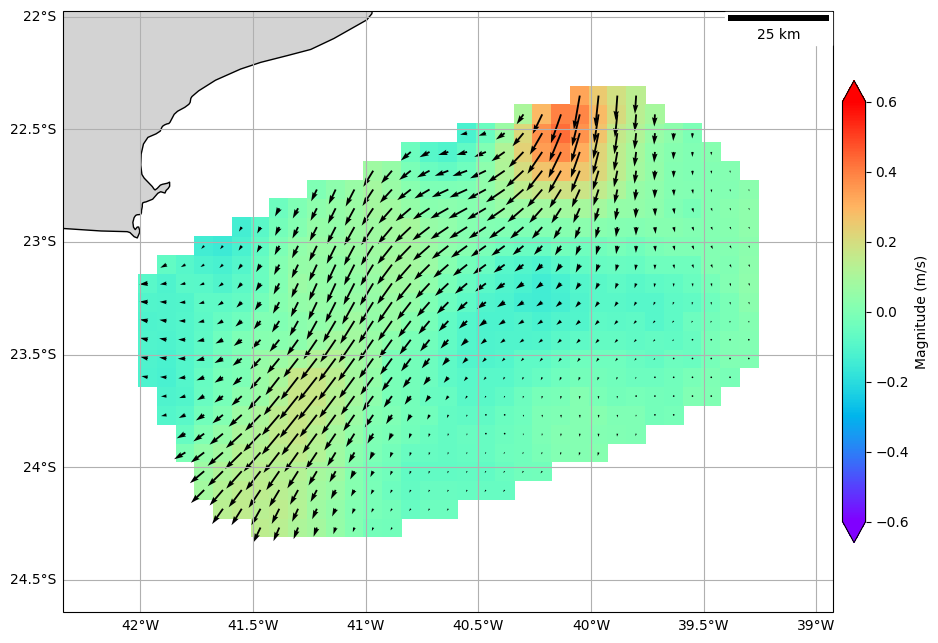

(1999, 32, 41)

In [125]:
lon, lat = np.meshgrid(file.lon.values, file.lat.values)

lat_idx=22     #13     13    22 
lon_idx=24     #24     14    24

print(lat_idx, lon_idx)


import matplotlib.pyplot as plt
import numpy as np

# Calculando a raiz quadrada do erro quadrático médio (RMSE)
rmse = np.sqrt(
    (np.nanmean(ui, axis=0) - uc[0] * 0)**2 + (np.nanmean(vi, axis=0) - uc[0] * 0)**2
)

# Criando o gráfico
import cartopy.crs as ccrs
import cartopy.feature as cfeature

from matplotlib_scalebar.scalebar import ScaleBar
from geopy.distance import geodesic

# Criando o gráfico com projeção Cartopy
fig, ax = plt.subplots(figsize=(10, 8), subplot_kw={'projection': ccrs.PlateCarree()})

# Plotando o RMSE usando pcolor com a colormap 'viridis'
#pc = ax.pcolor(lon, lat, np.nanmean(ui, axis=0) - uc[0]*0 ,vmin=-0.6, vmax=0.6,cmap='rainbow')
#pc = ax.pcolor(lon, lat, np.nanmean(vi, axis=0) - vc[0]*0 ,vmin=-0.6,  vmax=0.6,cmap='rainbow')
#pc = ax.pcolor(lon, lat, np.nanmean(us, axis=0) - uc[0]*0 ,vmin=-0.6, vmax=0.6,cmap='rainbow')
pc = ax.pcolor(lon, lat, np.nanmean(vs, axis=0) - uc[0]*0 ,vmin=-0.6, vmax=0.6,cmap='rainbow')

# Adicionando o ponto específico de interesse (lat_idx, lon_idx) com estrela branca

# Adicionando as setas do quiver (vetores de velocidade)
q = ax.quiver(lon, lat, np.mean(ui, axis=0) - uc[0] * 0, np.mean(vi, axis=0) - uc[0] * 0)




# Adicionando o colorbar para o RMSE
cbar = fig.colorbar(pc, ax=ax, orientation='vertical', pad=0.01, shrink=0.6, extend='both')  # O valor de shrink ajusta o tamanho
cbar.set_label("Magnitude (m/s)")

# Ajustando os eixos e a legenda
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
#ax.set_title("RMSE e Vetores de Velocidade")

# Exibindo a grade
ax.coastlines()
ax.add_feature(cfeature.BORDERS, linewidth=0.5)
ax.add_feature(cfeature.LAND, facecolor='lightgray')
ax.add_feature(cfeature.OCEAN, facecolor='white')

# Ajustando eixos e título
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
#ax.set_title("RMSE e Vetores de Velocidade")

# Grade com rótulos
gl = ax.gridlines(draw_labels=True)
gl.linewidth = 0.2  # ou outro valor menor que 1 para linhas mais finas
gl.top_labels = False    # Remove os rótulos do topo
gl.right_labels = False  # Remove os rótulos da direita# Exibindo o gráfico
plt.tight_layout()
dx = geodesic((-39.5, -22.5), (-39, -22.5)).km
scalebar = ScaleBar(dx, "km")
ax.add_artist(scalebar)

plt.savefig('v_res_component.png', dpi=200, transparent=False, bbox_inches="tight")

plt.show()


#plt.pcolor(lon, lat, ((np.nanmean(ui, axis=0) - uc[0] * 0)**2 +  (np.nanmean(vi, axis=0) - uc[0] * 0)**2)**(1/2), cmap='viridis')
#plt.plot(lon[lat_idx, lon_idx], lat[lat_idx, lon_idx], "*", color='white')
#plt.quiver(lon, lat, np.mean(ui, axis=0) - uc[0] * 0, np.mean(vi, axis=0) - uc[0] * 0)

#cax = plt.axes([0.38, 0.02, 0.25, 0.03])  # Aqui, você pode ajustar a posição (esquerda, embaixo, largura, altura)
#cbar = plt.colorbar(pc1, cax=cax, orientation='horizontal')
#cbar = plt.colorbar()
#cbar.set_label("RMSE")



vc.shape

(1997, 32, 41)
(1997, 32, 41, 2)
22 24


<ipython-input-126-1c4f827dd6c2>:30: RuntimeWarning: Mean of empty slice
  pc = ax.pcolor(lon, lat, ((np.nanmean(output_sequences[:,:,:,0], axis=0) - uc[0] * 0)**2 +  (np.nanmean(output_sequences[:,:,:,1], axis=0) - uc[0] * 0)**2)**(1/2), vmax=1,cmap='rainbow')
<ipython-input-126-1c4f827dd6c2>:58: RuntimeWarning: Mean of empty slice
  q = ax.quiver(lon, lat, np.nanmean(output_sequences[:,:,:,0], axis=0) - uc[0] * 0, np.nanmean(output_sequences[:,:,:,1], axis=0) - uc[0] * 0)


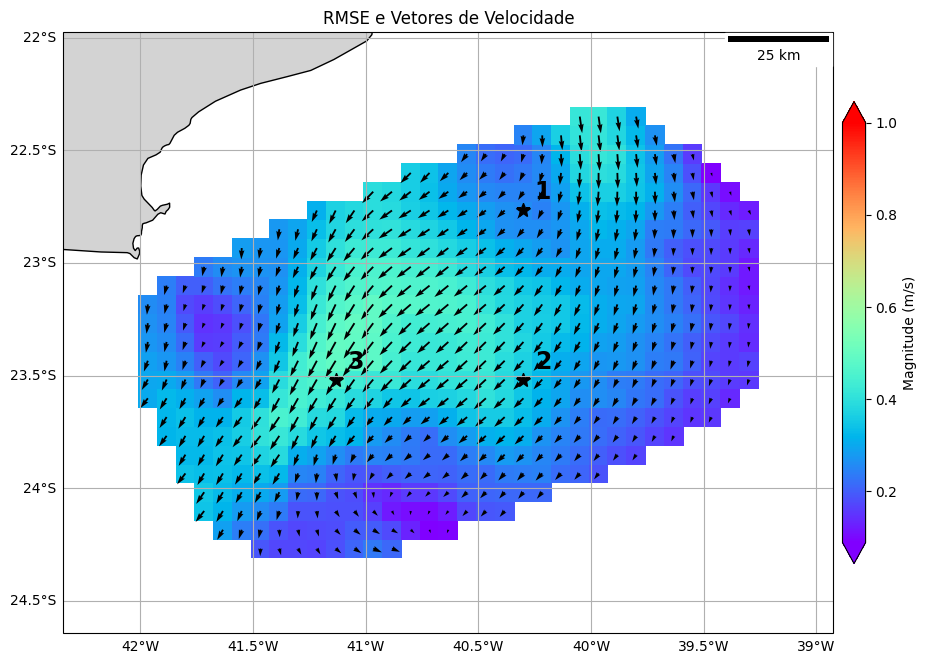

(1999, 32, 41)

In [126]:
print(ui.shape)
print(output_sequences.shape)
lon, lat = np.meshgrid(file.lon.values, file.lat.values)

lat_idx=22     #13     13    22 
lon_idx=24     #24     14    24

print(lat_idx, lon_idx)


import matplotlib.pyplot as plt
import numpy as np

# Calculando a raiz quadrada do erro quadrático médio (RMSE)
rmse = np.sqrt(
    (np.nanmean(ui, axis=0) - uc[0] * 0)**2 + (np.nanmean(vi, axis=0) - uc[0] * 0)**2
)

# Criando o gráfico
import cartopy.crs as ccrs
import cartopy.feature as cfeature

from matplotlib_scalebar.scalebar import ScaleBar
from geopy.distance import geodesic

# Criando o gráfico com projeção Cartopy
fig, ax = plt.subplots(figsize=(10, 8), subplot_kw={'projection': ccrs.PlateCarree()})

# Plotando o RMSE usando pcolor com a colormap 'viridis'
pc = ax.pcolor(lon, lat, ((np.nanmean(output_sequences[:,:,:,0], axis=0) - uc[0] * 0)**2 +  (np.nanmean(output_sequences[:,:,:,1], axis=0) - uc[0] * 0)**2)**(1/2), vmax=1,cmap='rainbow')

# Adicionando o ponto específico de interesse (lat_idx, lon_idx) com estrela branca

lat_idx=22     #13     13    22 
lon_idx=24     #24     14    24

ax.plot(lon[lat_idx, lon_idx], lat[lat_idx, lon_idx], "*", color='black', markersize=10)
ax.text(
    lon[lat_idx, lon_idx]+0.05, lat[lat_idx, lon_idx]+0.05, "1", color='black', fontsize=17, weight='bold'
)

lat_idx=13     #13     13    22 
lon_idx=24     #24     14    24

ax.plot(lon[lat_idx, lon_idx], lat[lat_idx, lon_idx], "*", color='black', markersize=10)
ax.text(
    lon[lat_idx, lon_idx]+0.05, lat[lat_idx, lon_idx]+0.05, "2", color='black', fontsize=17, weight='bold'
)
lat_idx=13     #13     13    22 
lon_idx=14     #24     14    24

ax.plot(lon[lat_idx, lon_idx], lat[lat_idx, lon_idx], "*", color='black', markersize=10)
ax.text(
    lon[lat_idx, lon_idx]+0.05, lat[lat_idx, lon_idx]+0.05, "3", color='black', fontsize=17, weight='bold'
)

# Adicionando as setas do quiver (vetores de velocidade)
q = ax.quiver(lon, lat, np.nanmean(output_sequences[:,:,:,0], axis=0) - uc[0] * 0, np.nanmean(output_sequences[:,:,:,1], axis=0) - uc[0] * 0)




# Adicionando o colorbar para o RMSE
cbar = fig.colorbar(pc, ax=ax, orientation='vertical', pad=0.01, shrink=0.6, extend='both')  # O valor de shrink ajusta o tamanho
cbar.set_label("Magnitude (m/s)")

# Ajustando os eixos e a legenda
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.set_title("RMSE e Vetores de Velocidade")

# Exibindo a grade
ax.coastlines()
ax.add_feature(cfeature.BORDERS, linewidth=0.5)
ax.add_feature(cfeature.LAND, facecolor='lightgray')
ax.add_feature(cfeature.OCEAN, facecolor='white')

# Ajustando eixos e título
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
#ax.set_title("RMSE e Vetores de Velocidade")

# Grade com rótulos
gl = ax.gridlines(draw_labels=True)
gl.linewidth = 0.2  # ou outro valor menor que 1 para linhas mais finas
gl.top_labels = False    # Remove os rótulos do topo
gl.right_labels = False  # Remove os rótulos da direita# Exibindo o gráfico
plt.tight_layout()
dx = geodesic((-39.5, -22.5), (-39, -22.5)).km
scalebar = ScaleBar(dx, "km")
ax.add_artist(scalebar)

plt.show()


#plt.pcolor(lon, lat, ((np.nanmean(ui, axis=0) - uc[0] * 0)**2 +  (np.nanmean(vi, axis=0) - uc[0] * 0)**2)**(1/2), cmap='viridis')
#plt.plot(lon[lat_idx, lon_idx], lat[lat_idx, lon_idx], "*", color='white')
#plt.quiver(lon, lat, np.mean(ui, axis=0) - uc[0] * 0, np.mean(vi, axis=0) - uc[0] * 0)

#cax = plt.axes([0.38, 0.02, 0.25, 0.03])  # Aqui, você pode ajustar a posição (esquerda, embaixo, largura, altura)
#cbar = plt.colorbar(pc1, cax=cax, orientation='horizontal')
#cbar = plt.colorbar()
#cbar.set_label("RMSE")



vc.shape

<ipython-input-127-44c31cac24e4>:24: RuntimeWarning: Mean of empty slice
  magnitude_obs = np.sqrt((np.nanmean(output_sequences[:, :, :, 0], axis=0))**2 +
<ipython-input-127-44c31cac24e4>:25: RuntimeWarning: Mean of empty slice
  (np.nanmean(output_sequences[:, :, :, 1], axis=0))**2)
<ipython-input-127-44c31cac24e4>:51: RuntimeWarning: Mean of empty slice
  np.nanmean(output_sequences[:, :, :, 0], axis=0),
<ipython-input-127-44c31cac24e4>:52: RuntimeWarning: Mean of empty slice
  np.nanmean(output_sequences[:, :, :, 1], axis=0),
<ipython-input-127-44c31cac24e4>:74: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1])


-40.29999999999994 -22.766666666666694 1
-40.29999999999994 -23.516666666666683 2
-41.1333333333333 -23.516666666666683 3


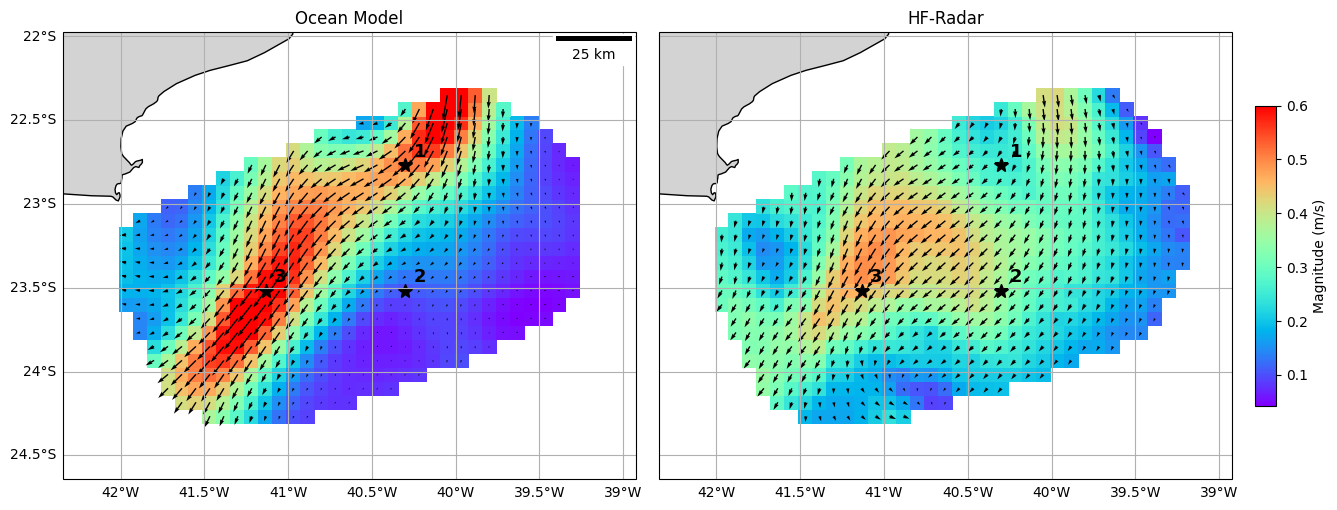

In [127]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib_scalebar.scalebar import ScaleBar
from geopy.distance import geodesic
import numpy as np

# Substitua esses arrays pelos seus dados reais
# ui, vi, us, vs, output_sequences, uc, lon, lat devem estar definidos
# Aqui está apenas a estrutura para te guiar

# Parâmetros para barra de escala
dx = geodesic((-39.5, -22.5), (-39, -22.5)).km
scalebar = ScaleBar(dx, "km")

# Posição dos pontos
points = [(22, 24, "1"), (13, 24, "2"), (13, 14, "3")]

# Figura e eixos
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6), subplot_kw={'projection': ccrs.PlateCarree()})

# Magnitudes
magnitude_model = np.sqrt((np.nanmean(ui, axis=0)- uc[0] * 0)**2 + (np.nanmean(vi, axis=0)- uc[0] * 0)**2)
magnitude_obs = np.sqrt((np.nanmean(output_sequences[:, :, :, 0], axis=0))**2 +
                        (np.nanmean(output_sequences[:, :, :, 1], axis=0))**2)

# Ocean Model (esquerda)
pc1 = ax1.pcolor(lon, lat, magnitude_model, vmax=0.6, cmap='rainbow', transform=ccrs.PlateCarree())
ax1.quiver(lon, lat, np.nanmean(ui, axis=0)- uc[0] * 0, np.nanmean(vi, axis=0)- uc[0] * 0, transform=ccrs.PlateCarree())
ax1.set_title("Ocean Model")
ax1.coastlines()
ax1.add_feature(cfeature.BORDERS, linewidth=0.5)
ax1.add_feature(cfeature.LAND, facecolor='lightgray')
ax1.add_feature(cfeature.OCEAN, facecolor='white')
ax1.add_artist(scalebar)

# Pontos numerados
for lat_idx, lon_idx, label in points:
    print(lon[lat_idx, lon_idx], lat[lat_idx, lon_idx], label)    
    ax1.plot(lon[lat_idx, lon_idx], lat[lat_idx, lon_idx], "*", color='black', markersize=10)
    ax1.text(lon[lat_idx, lon_idx] + 0.05, lat[lat_idx, lon_idx] + 0.05, label,
             color='black', fontsize=13, weight='bold')

gl1 = ax1.gridlines(draw_labels=True)
gl1.top_labels = False
gl1.right_labels = False

# HF-Radar (direita)
pc2 = ax2.pcolor(lon, lat, magnitude_obs, vmax=0.6, cmap='rainbow', transform=ccrs.PlateCarree())
ax2.quiver(lon, lat,
           np.nanmean(output_sequences[:, :, :, 0], axis=0),
           np.nanmean(output_sequences[:, :, :, 1], axis=0),
           transform=ccrs.PlateCarree())
ax2.set_title("HF-Radar")
ax2.coastlines()
ax2.add_feature(cfeature.BORDERS, linewidth=0.5)
ax2.add_feature(cfeature.LAND, facecolor='lightgray')
ax2.add_feature(cfeature.OCEAN, facecolor='white')
gl2 = ax2.gridlines(draw_labels=True)
gl2.top_labels = False
gl2.right_labels = False
gl2.left_labels = False
gl2.bottom_labels = True
for lat_idx, lon_idx, label in points:
    ax2.plot(lon[lat_idx, lon_idx], lat[lat_idx, lon_idx], "*", color='black', markersize=10)
    ax2.text(lon[lat_idx, lon_idx] + 0.05, lat[lat_idx, lon_idx] + 0.05, label,
             color='black', fontsize=13, weight='bold')

# Colorbar à direita
cax = fig.add_axes([0.90, 0.25, 0.015, 0.5])
cbar = fig.colorbar(pc2, cax=cax)
cbar.set_label("Magnitude (m/s)")

plt.tight_layout(rect=[0, 0, 0.9, 1])
plt.savefig('mercvscodar.png', dpi=200, transparent=False, bbox_inches="tight")
plt.show()

22 24


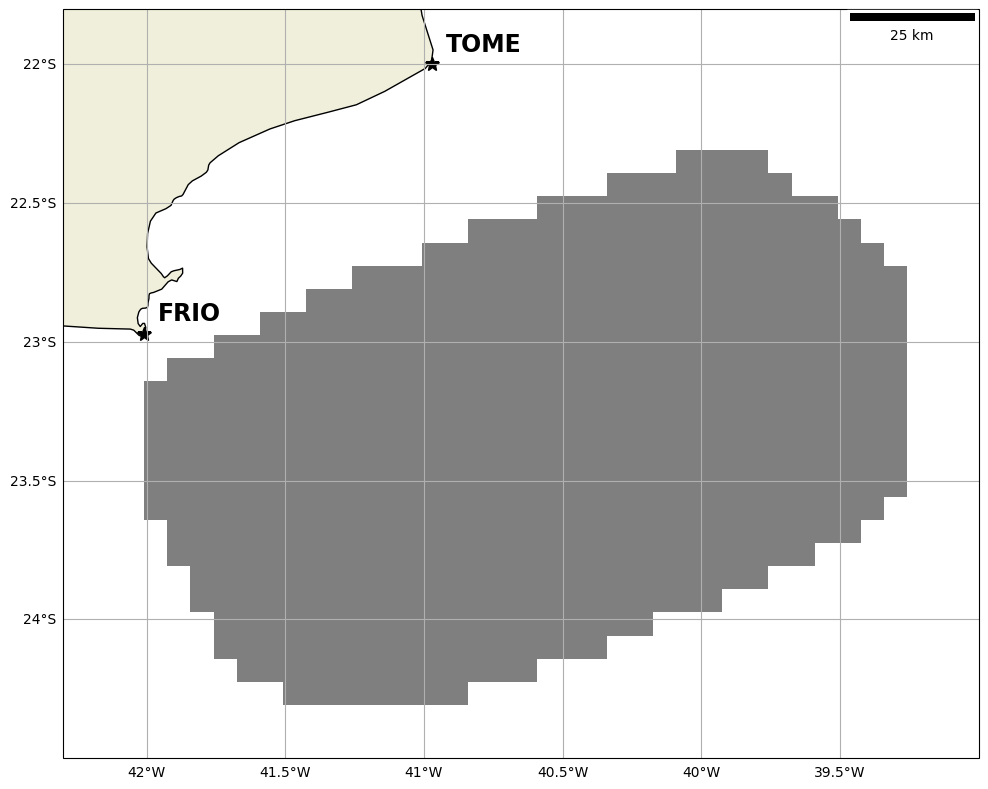

(1999, 32, 41)

In [128]:
#STUDY AREA

lon, lat = np.meshgrid(file.lon.values, file.lat.values)

lat_idx=22     #13     13    22 
lon_idx=24     #24     14    24

print(lat_idx, lon_idx)


import matplotlib.pyplot as plt
import numpy as np

# Calculando a raiz quadrada do erro quadrático médio (RMSE)
rmse = np.sqrt(
    (np.nanmean(ui, axis=0) - uc[0] * 0)**2 + (np.nanmean(vi, axis=0) - uc[0] * 0)**2
)

# Criando o gráfico
import cartopy.crs as ccrs
import cartopy.feature as cfeature

from matplotlib_scalebar.scalebar import ScaleBar
from geopy.distance import geodesic

# Criando o gráfico com projeção Cartopy
fig, ax = plt.subplots(figsize=(10, 8), subplot_kw={'projection': ccrs.PlateCarree()})

aaa=10+0*((np.nanmean(ui, axis=0) - uc[0] * 0)**2 +  (np.nanmean(vi, axis=0) - uc[0] * 0)**2)**(1/2)
# Plotando o RMSE usando pcolor com a colormap 'viridis'
pc = ax.pcolormesh(lon, lat,aaa,cmap='gray',alpha=0.5)

# Adicionando o ponto específico de interesse (lat_idx, lon_idx) com estrela branca

lat_idx=-22     #13     13    22 
lon_idx=-40.97     #24     14    24

ax.plot(lon_idx, lat_idx, "*", color='black', markersize=10)
ax.text(
    lon_idx+0.05, lat_idx+0.05, "TOME", color='black', fontsize=17, weight='bold'
)


lat_idx=-22.97     #13     13    22 
lon_idx=-42.01     #24     14    24

ax.plot(lon_idx, lat_idx, "*", color='black', markersize=10)
ax.text(
    lon_idx+0.05, lat_idx+0.05, "FRIO", color='black', fontsize=17, weight='bold'
)


# Adicionando as setas do quiver (vetores de velocidade)
#q = ax.quiver(lon, lat, np.mean(ui, axis=0) - uc[0] * 0, np.mean(vi, axis=0) - uc[0] * 0)




# Adicionando o colorbar para o RMSE

# Ajustando os eixos e a legenda
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
#ax.set_title("RMSE e Vetores de Velocidade")

# Exibindo a grade
ax.coastlines()
ax.add_feature(cfeature.BORDERS, linewidth=0.5)
#ax.add_feature(cfeature.LAND, facecolor='lightgray')
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.OCEAN, facecolor='white')

# Ajustando eixos e título
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
#ax.set_title("RMSE e Vetores de Velocidade")
ax.set_xlim(-42.3, -39)
ax.set_ylim(-24.5, -21.8)
# Grade com rótulos
gl = ax.gridlines(draw_labels=True)
gl.linewidth = 0.2  # ou outro valor menor que 1 para linhas mais finas
gl.top_labels = False    # Remove os rótulos do topo
gl.right_labels = False  # Remove os rótulos da direita# Exibindo o gráfico
plt.tight_layout()
dx = geodesic((-39.5, -22.5), (-39, -22.5)).km
scalebar = ScaleBar(dx, "km")
ax.add_artist(scalebar)
plt.savefig('study_area.png',dpi=200, transparent=False, bbox_inches="tight")

plt.show()


#plt.pcolor(lon, lat, ((np.nanmean(ui, axis=0) - uc[0] * 0)**2 +  (np.nanmean(vi, axis=0) - uc[0] * 0)**2)**(1/2), cmap='viridis')
#plt.plot(lon[lat_idx, lon_idx], lat[lat_idx, lon_idx], "*", color='white')
#plt.quiver(lon, lat, np.mean(ui, axis=0) - uc[0] * 0, np.mean(vi, axis=0) - uc[0] * 0)

#cax = plt.axes([0.38, 0.02, 0.25, 0.03])  # Aqui, você pode ajustar a posição (esquerda, embaixo, largura, altura)
#cbar = plt.colorbar(pc1, cax=cax, orientation='horizontal')
#cbar = plt.colorbar()
#cbar.set_label("RMSE")



vc.shape

In [129]:
mask = lon[ :, :] < -41.5

model_v = np.where(mask, np.nan, vi[:, :, :])
measured_v = np.where(mask, np.nan, output_sequences[:, :, :, -1])

measured_v.shape
idx
np.percentile(rmse_model, 50)
a

NameError: name 'rmse_model' is not defined

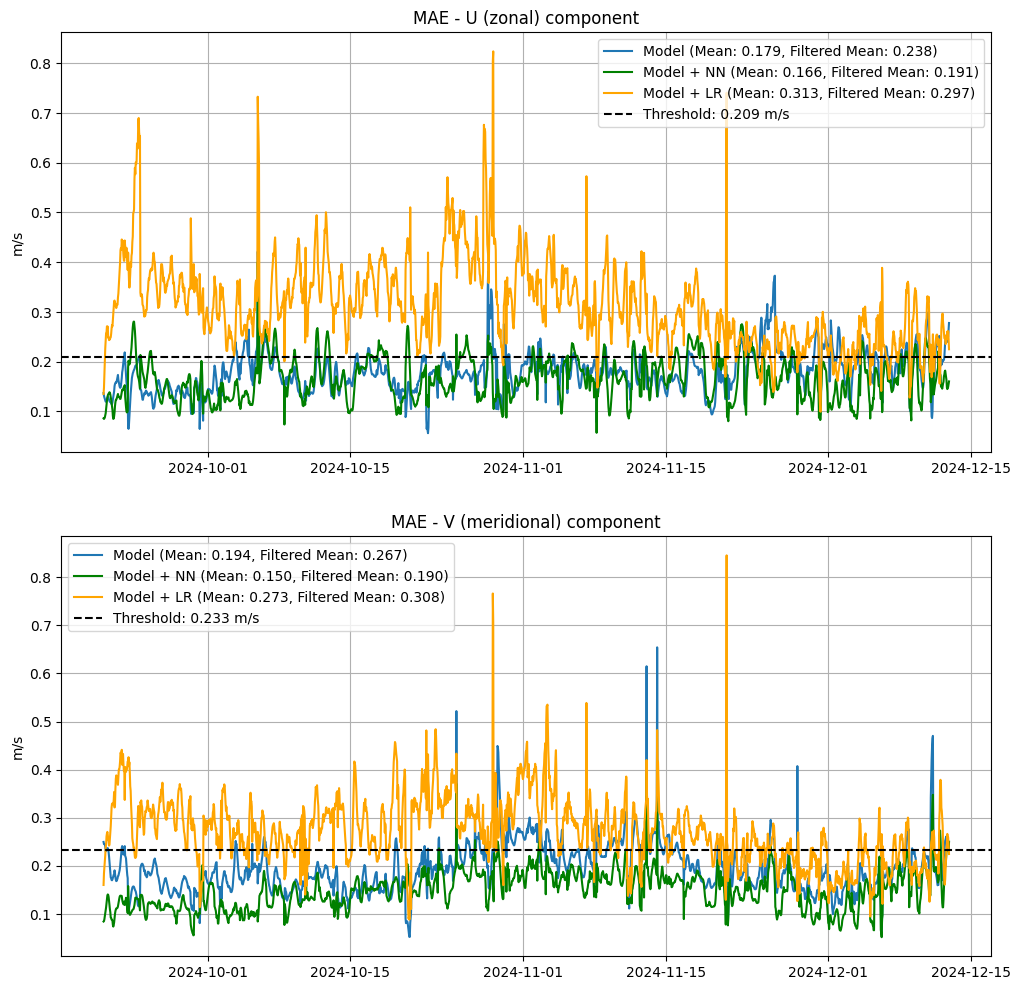

In [130]:
import numpy as np
import matplotlib.pyplot as plt

# Função para calcular MAE ao longo do espaço
def calculate_mae_spatial(model, measured):
    return np.nanmean(np.abs(model - measured), axis=(1, 2))

# =========================
# Componente V (meridional)
# =========================
mask = lon[ :, :] < -50

model_v = np.where(mask, np.nan, vi[:, :, :])
measured_v = np.where(mask, np.nan, output_sequences[:, :, :, -1])
corrected_v = np.where(mask, np.nan, (vi + vs)[:, :, :])
corrected_vl = np.where(mask, np.nan, (vi + vsl)[:, :, :])

mae_model = calculate_mae_spatial(model_v, measured_v)
mae_corrected = calculate_mae_spatial(corrected_v, measured_v)
mae_correctedl = calculate_mae_spatial(corrected_vl, measured_v)

mean_mae_model = np.nanmean(mae_model)
mean_mae_corrected = np.nanmean(mae_corrected)
mean_mae_correctedl = np.nanmean(mae_correctedl)

limv = np.percentile(mae_model, 80)

mean_mae_model_filtered = np.mean(mae_model[mae_model > limv])
mean_mae_corrected_filtered = np.mean(mae_corrected[mae_model > limv])
mean_mae_corrected_filteredl = np.mean(mae_correctedl[mae_model > limv])

fig, axs = plt.subplots(2, 1, figsize=(12, 12))

axs[1].plot(filem.time[a:idx], mae_model, label=f'Model (Mean: {mean_mae_model:.3f}, Filtered Mean: {mean_mae_model_filtered:.3f})')
axs[1].plot(filem.time[a:idx], mae_corrected, label=f'Model + NN (Mean: {mean_mae_corrected:.3f}, Filtered Mean: {mean_mae_corrected_filtered:.3f})', color='green')
axs[1].plot(filem.time[a:idx], mae_correctedl, label=f'Model + LR (Mean: {mean_mae_correctedl:.3f}, Filtered Mean: {mean_mae_corrected_filteredl:.3f})', color='orange')
axs[1].axhline(y=np.round(limv, 3), color='black', linestyle='--', label=f'Threshold: {np.round(limv, 3)} m/s')
axs[1].set_title("MAE - V (meridional) component")
axs[1].set_ylabel('m/s')
axs[1].legend()
axs[1].grid()

# =========================
# Componente U (zonal)
# =========================

model_v = np.where(mask, np.nan, ui[:, :, :])
measured_v = np.where(mask, np.nan, output_sequences[:, :, :, 0])
corrected_v = np.where(mask, np.nan, (ui + us)[:, :, :])
corrected_vl = np.where(mask, np.nan, (ui + usl)[:, :, :])

mae_model = calculate_mae_spatial(model_v, measured_v)
mae_corrected = calculate_mae_spatial(corrected_v, measured_v)
mae_correctedl = calculate_mae_spatial(corrected_vl, measured_v)

mean_mae_model = np.nanmean(mae_model)
mean_mae_corrected = np.nanmean(mae_corrected)
mean_mae_correctedl = np.nanmean(mae_correctedl)

limv = np.percentile(mae_model, 80)

mean_mae_model_filtered = np.mean(mae_model[mae_model > limv])
mean_mae_corrected_filtered = np.mean(mae_corrected[mae_model > limv])
mean_mae_corrected_filteredl = np.mean(mae_correctedl[mae_model > limv])

axs[0].plot(filem.time[a:idx], mae_model, label=f'Model (Mean: {mean_mae_model:.3f}, Filtered Mean: {mean_mae_model_filtered:.3f})')
axs[0].plot(filem.time[a:idx], mae_corrected, label=f'Model + NN (Mean: {mean_mae_corrected:.3f}, Filtered Mean: {mean_mae_corrected_filtered:.3f})', color='green')
axs[0].plot(filem.time[a:idx], mae_correctedl, label=f'Model + LR (Mean: {mean_mae_correctedl:.3f}, Filtered Mean: {mean_mae_corrected_filteredl:.3f})', color='orange')
axs[0].axhline(y=np.round(limv, 3), color='black', linestyle='--', label=f'Threshold: {np.round(limv, 3)} m/s')
axs[0].set_ylabel('m/s')
axs[0].set_title("MAE - U (zonal) component")
axs[0].legend()
axs[0].grid()

plt.savefig('mae_1ts.png', dpi=200, transparent=False, bbox_inches="tight")

0.26743523630311716


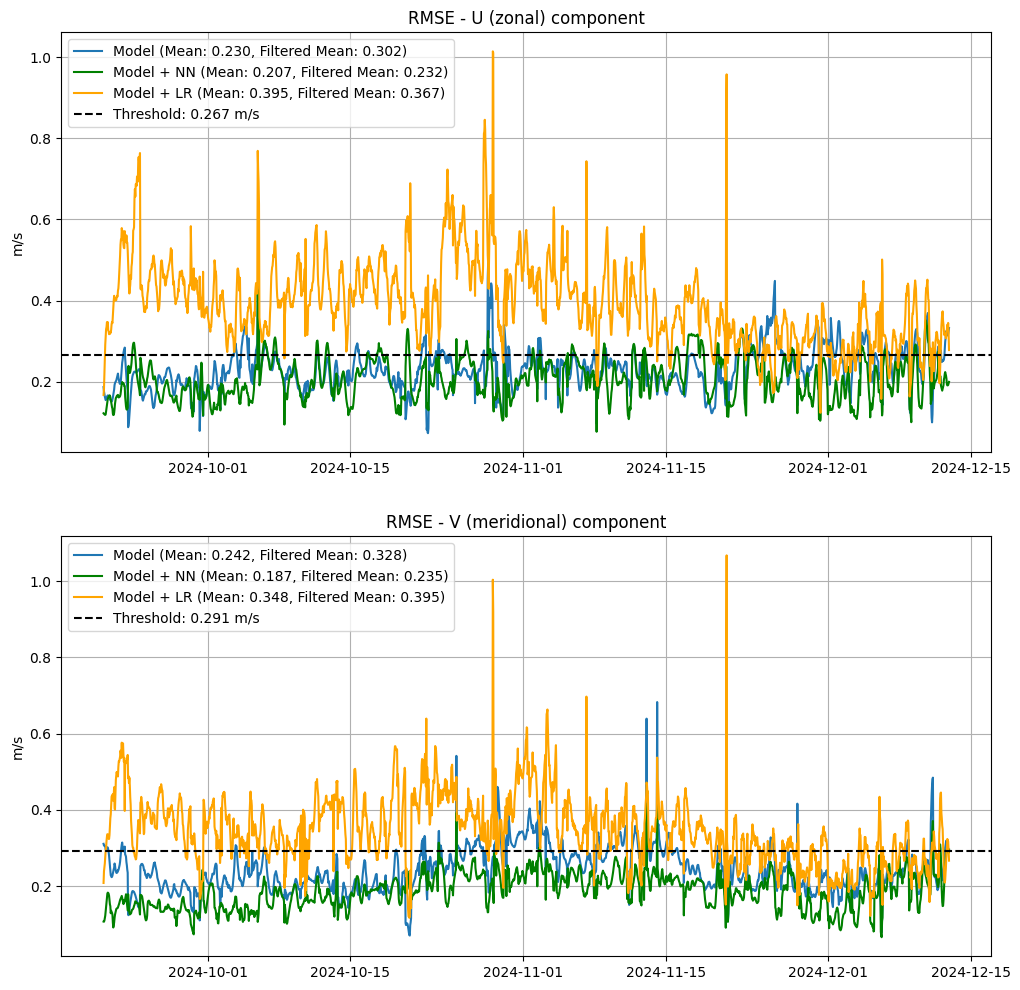

In [131]:
import numpy as np
import matplotlib.pyplot as plt

# Função para calcular RMSE ao longo do espaço
def calculate_rmse_spatial(model, measured):
    return np.sqrt(np.nanmean((model - measured) ** 2, axis=(1, 2)))

model_v = vi[:, :, :]
measured_v = output_sequences[:, :, :, -1]
corrected_v = (vi + vs)[:, :, :]
corrected_vl = (vi + vsl)[:, :, :]

mask = lon[ :, :] < -50

model_v = np.where(mask, np.nan, vi[:, :, :])
measured_v = np.where(mask, np.nan, output_sequences[:, :, :, -1])
corrected_v = np.where(mask, np.nan, (vi + vs)[:, :, :])
corrected_vl = np.where(mask, np.nan, (vi + vsl)[:, :, :])


# Cálculo do RMSE espacial para cada tempo
rmse_model = calculate_rmse_spatial(model_v, measured_v)
rmse_corrected = calculate_rmse_spatial(corrected_v, measured_v)
rmse_correctedl = calculate_rmse_spatial(corrected_vl, measured_v)

# Média do RMSE geral
mean_rmse_model = np.nanmean(rmse_model)
mean_rmse_corrected = np.nanmean(rmse_corrected)
mean_rmse_correctedl = np.nanmean(rmse_correctedl)

# Média do RMSE apenas para valores maiores que 0.4
limv=np.percentile(rmse_model, 80)

mean_rmse_model_filtered = np.mean(rmse_model[rmse_model > limv])
mean_rmse_corrected_filtered = np.mean(rmse_corrected[rmse_model > limv])
mean_rmse_corrected_filteredl = np.mean(rmse_correctedl[rmse_model > limv])

# Plot da série temporal do RMSE

fig, axs = plt.subplots(2, 1, figsize=(12, 12))

#plt.figure(figsize=(10, 5))
axs[1].plot(filem.time[a:idx], rmse_model, label=f'Model (Mean: {mean_rmse_model:.3f}, Filtered Mean: {mean_rmse_model_filtered:.3f})')
axs[1].plot(filem.time[a:idx],rmse_corrected, label=f'Model + NN (Mean: {mean_rmse_corrected:.3f}, Filtered Mean: {mean_rmse_corrected_filtered:.3f})', color='green')
axs[1].plot(filem.time[a:idx],rmse_correctedl, label=f'Model + LR (Mean: {mean_rmse_correctedl:.3f}, Filtered Mean: {mean_rmse_corrected_filteredl:.3f})', color='orange')
#axs10].set_ylabel('Time')
axs[1].set_title("RMSE - V (meridional) component")
axs[1].set_ylabel('m/s')
#axs0].title('Spatial RMSE over Time')
axs[1].axhline(y=np.round(limv, 3), color='black', linestyle='--', label=f'Threshold: {np.round(limv, 3)} m/s')
axs[1].legend()
axs[1].grid()

model_v = np.where(mask, np.nan, ui[:, :, :])
measured_v = np.where(mask, np.nan, output_sequences[:, :, :, 0])
corrected_v = np.where(mask, np.nan, (ui + us)[:, :, :])
corrected_vl = np.where(mask, np.nan, (ui + usl)[:, :, :])



# Cálculo do RMSE espacial para cada tempo
rmse_model = calculate_rmse_spatial(model_v, measured_v)
rmse_corrected = calculate_rmse_spatial(corrected_v, measured_v)
rmse_correctedl = calculate_rmse_spatial(corrected_vl, measured_v)

# Média do RMSE geral
mean_rmse_model = np.nanmean(rmse_model)
mean_rmse_corrected = np.nanmean(rmse_corrected)
mean_rmse_correctedl = np.nanmean(rmse_correctedl)

limv=np.percentile(rmse_model, 80)

# Média do RMSE apenas para valores maiores que 0.4
mean_rmse_model_filtered = np.mean(rmse_model[rmse_model > limv])
mean_rmse_corrected_filtered = np.mean(rmse_corrected[rmse_model > limv])
mean_rmse_corrected_filteredl = np.mean(rmse_correctedl[rmse_model > limv])

# Plot da série temporal do RMSE
#plt.figure(figsize=(10, 5))
axs[0].plot(filem.time[a:idx], rmse_model, label=f'Model (Mean: {mean_rmse_model:.3f}, Filtered Mean: {mean_rmse_model_filtered:.3f})')
axs[0].plot(filem.time[a:idx],rmse_corrected, label=f'Model + NN (Mean: {mean_rmse_corrected:.3f}, Filtered Mean: {mean_rmse_corrected_filtered:.3f})', color='green')
axs[0].plot(filem.time[a:idx],rmse_correctedl, label=f'Model + LR (Mean: {mean_rmse_correctedl:.3f}, Filtered Mean: {mean_rmse_corrected_filteredl:.3f})', color='orange')
#axs10].set_ylabel('Time')
axs[0].axhline(y=np.round(limv, 3), color='black', linestyle='--', label=f'Threshold: {np.round(limv, 3)} m/s')
axs[0].set_ylabel('m/s')
axs[0].set_title("RMSE - U (zonal) component")
#axs0].title('Spatial RMSE over Time')
axs[0].legend()
axs[0].grid()
plt.savefig('rmse_1ts.png',dpi=200, transparent=False, bbox_inches="tight")

#axs[0].show()


print(limv)

0.6035789190101254


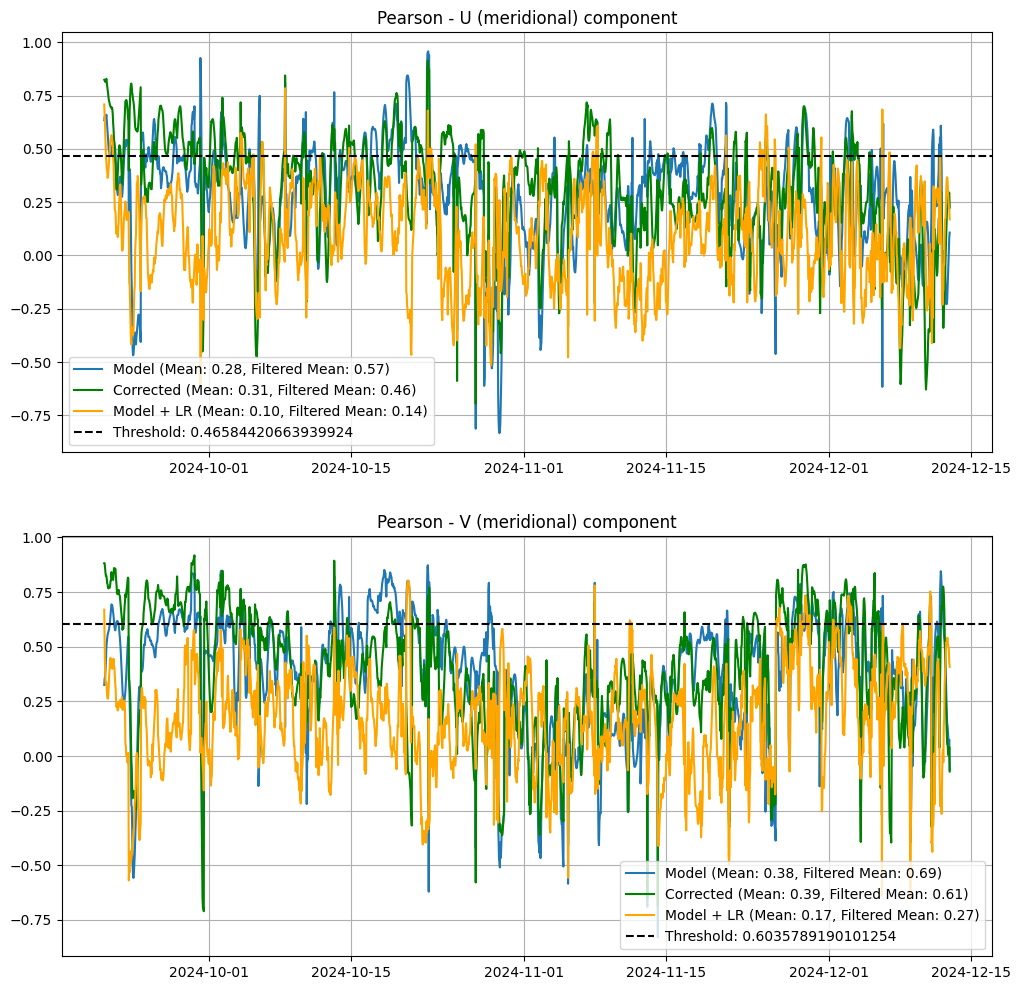

In [132]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

# Função para calcular o coeficiente de correlação de Pearson ao longo do espaço
def calculate_pearson_spatial(model, measured):
    """
    Calcula o coeficiente de correlação de Pearson ao longo da dimensão temporal.
    Retorna um array 1D de coeficientes para cada instante de tempo.
    """
    pearson_values = np.full(model.shape[0], np.nan)  # Inicializa com NaN

    for t in range(model.shape[0]):  # Loop sobre o tempo
        model_flat = model[t].flatten()
        measured_flat = measured[t].flatten()

        # Remover NaNs antes de calcular Pearson
        valid = ~np.isnan(model_flat) & ~np.isnan(measured_flat)

        if np.sum(valid) > 2:  # Só calcula se houver mais de 2 pontos válidos
            pearson_values[t], _ = pearsonr(model_flat[valid], measured_flat[valid])

    return pearson_values

# Aplicar a máscara
mask = lon[:, :] < -50

model_v = np.where(mask, np.nan, vi[:, :, :])
measured_v = np.where(mask, np.nan, output_sequences[:, :, :, -1])
corrected_v = np.where(mask, np.nan, (vi + vs)[:, :, :])
corrected_vl = np.where(mask, np.nan, (vi + vsl)[:, :, :])

# Cálculo do coeficiente de correlação espacial para cada tempo
pearson_model = calculate_pearson_spatial(model_v, measured_v)
pearson_corrected = calculate_pearson_spatial(corrected_v, measured_v)
pearson_correctedl = calculate_pearson_spatial(corrected_vl, measured_v)

# Média do coeficiente de Pearson geral
mean_pearson_model = np.nanmean(pearson_model)
mean_pearson_corrected = np.nanmean(pearson_corrected)
mean_pearson_correctedl = np.nanmean(pearson_correctedl)

limv=0.25

limv=np.percentile(pearson_model, 80)
print(limv)

# Média do coeficiente de Pearson apenas para valores maiores que 0.3
mean_pearson_model_filtered = np.nanmean(pearson_model[pearson_model > limv])
mean_pearson_corrected_filtered = np.nanmean(pearson_corrected[pearson_model >limv])
mean_pearson_corrected_filteredl = np.nanmean(pearson_correctedl[pearson_model > limv])


fig, axs = plt.subplots(2, 1, figsize=(12, 12))

#plt.figure(figsize=(10, 5))
axs[1].plot(filem.time[a:idx], pearson_model, label=f'Model (Mean: {mean_pearson_model:.2f}, Filtered Mean: {mean_pearson_model_filtered:.2f})')
axs[1].plot(filem.time[a:idx],pearson_corrected, label=f'Corrected (Mean: {mean_pearson_corrected:.2f}, Filtered Mean: {mean_pearson_corrected_filtered:.2f})', color='green')
axs[1].plot(filem.time[a:idx],pearson_correctedl, label=f'Model + LR (Mean: {mean_pearson_correctedl:.2f}, Filtered Mean: {mean_pearson_corrected_filteredl:.2f})', color='orange')
#axs10].set_ylabel('Time')
axs[1].set_title("Pearson - V (meridional) component")
#axs[1].set_ylabel('m/s')
#axs0].title('Spatial RMSE over Time')
axs[1].axhline(y=limv, color='black', linestyle='--', label=f'Threshold: {limv}')
axs[1].legend()
axs[1].grid()


model_v = np.where(mask, np.nan, ui[:, :, :])
measured_v = np.where(mask, np.nan, output_sequences[:, :, :, 0])
corrected_v = np.where(mask, np.nan, (ui + us)[:, :, :])
corrected_vl = np.where(mask, np.nan, (ui + usl)[:, :, :])

# Cálculo do coeficiente de correlação espacial para cada tempo
pearson_model = calculate_pearson_spatial(model_v, measured_v)
pearson_corrected = calculate_pearson_spatial(corrected_v, measured_v)
pearson_correctedl = calculate_pearson_spatial(corrected_vl, measured_v)


limv=np.percentile(pearson_model, 80)


# Média do coeficiente de Pearson geral
mean_pearson_model = np.nanmean(pearson_model)
mean_pearson_corrected = np.nanmean(pearson_corrected)
mean_pearson_correctedl = np.nanmean(pearson_correctedl)

# Média do coeficiente de Pearson apenas para valores maiores que 0.3
mean_pearson_model_filtered = np.nanmean(pearson_model[pearson_model > limv])
mean_pearson_corrected_filtered = np.nanmean(pearson_corrected[pearson_model >limv])
mean_pearson_corrected_filteredl = np.nanmean(pearson_correctedl[pearson_model > limv])



#plt.figure(figsize=(10, 5))
axs[0].plot(filem.time[a:idx], pearson_model, label=f'Model (Mean: {mean_pearson_model:.2f}, Filtered Mean: {mean_pearson_model_filtered:.2f})')
axs[0].plot(filem.time[a:idx],pearson_corrected, label=f'Corrected (Mean: {mean_pearson_corrected:.2f}, Filtered Mean: {mean_pearson_corrected_filtered:.2f})', color='green')
axs[0].plot(filem.time[a:idx],pearson_correctedl, label=f'Model + LR (Mean: {mean_pearson_correctedl:.2f}, Filtered Mean: {mean_pearson_corrected_filteredl:.2f})', color='orange')
#axs10].set_ylabel('Time')
axs[0].set_title("Pearson - U (meridional) component")
#axs[1].set_ylabel('m/s')
#axs0].title('Spatial RMSE over Time')
axs[0].axhline(y=limv, color='black', linestyle='--', label=f'Threshold: {limv}')
axs[0].legend()
axs[0].grid()

# Plot da série temporal do coeficiente de correlação de Pearson
#plt.figure(figsize=(10, 5))
#plt.plot(pearson_model, label=f'Model (Mean: {mean_pearson_model:.2f}, Filtered Mean: {mean_pearson_model_filtered:.2f})')
#plt.plot(pearson_corrected, label=f'Corrected (Mean: {mean_pearson_corrected:.2f}, Filtered Mean: {mean_pearson_corrected_filtered:.2f})')
#plt.xlabel('Time')
#plt.ylabel('Pearson Correlation')
#plt.title('Spatial Pearson Correlation over Time')
#plt.legend()
#plt.grid()
plt.savefig('pearson_1ts.png',dpi=200, transparent=False, bbox_inches="tight")

plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Função para calcular o viés ao longo do espaço
def calculate_bias_spatial(model, measured):
    """
    Calcula o viés (bias) ao longo da dimensão espacial.
    Retorna um array 1D com o viés para cada instante de tempo.
    """
    bias_values = np.nanmean(model - measured, axis=(1, 2))  # Média espacial ignorando NaNs
    return bias_values

# Aplicar a máscara
mask = lon[:, :] < -43

model_v = np.where(mask, np.nan, vi[:, :, :])
measured_v = np.where(mask, np.nan, output_sequences[:, :, :, -1])
corrected_v = np.where(mask, np.nan, (vi + vs)[:, :, :])
corrected_vl = np.where(mask, np.nan, (vi + vsl)[:, :, :])

# Cálculo do viés espacial para cada tempo
bias_model = calculate_bias_spatial(model_v, measured_v)
bias_corrected = calculate_bias_spatial(corrected_v, measured_v)
bias_correctedl = calculate_bias_spatial(corrected_vl, measured_v)

# Média do viés geral
mean_bias_model = np.nanmean(np.abs(bias_model))
mean_bias_corrected = np.nanmean(np.abs(bias_corrected))
mean_bias_correctedl = np.nanmean(np.abs(bias_correctedl))

# Média do viés apenas para valores maiores que 0.3
#limv=0.1

limv=np.percentile(np.abs(bias_model), 80)

print(limv)

mean_bias_model_filtered = np.nanmean(np.abs(bias_model[np.abs(bias_model) > limv]))
mean_bias_corrected_filtered = np.nanmean(np.abs(bias_corrected[np.abs(bias_model) > limv]))
mean_bias_corrected_filteredl = np.nanmean(np.abs(bias_correctedl[np.abs(bias_model) > limv]))


fig, axs = plt.subplots(2, 1, figsize=(12, 12))

#plt.figure(figsize=(10, 5))
axs[1].plot(filem.time[a:idx], bias_model, label=f'Model (Mean: {mean_bias_model:.2f}, Filtered Mean: {mean_bias_model_filtered:.2f})')
axs[1].plot(filem.time[a:idx],bias_corrected, label=f'Corrected (Mean: {mean_bias_corrected:.2f}, Filtered Mean: {mean_bias_corrected_filtered:.2f})', color='green')
axs[1].plot(filem.time[a:idx],bias_correctedl, label=f'Model + LR (Mean: {mean_bias_correctedl:.2f}, Filtered Mean: {mean_bias_corrected_filteredl:.2f})', color='orange')
#axs10].set_ylabel('Time')
axs[1].set_title("Bias - V (meridional) component")
#axs[1].set_ylabel('m/s')
#axs0].title('Spatial RMSE over Time')
axs[1].axhline(y=limv, color='black', linestyle='--', label=f'Threshold: {limv}')
axs[1].axhline(y=-limv, color='black', linestyle='--', label=f'Threshold: {limv}')

axs[1].legend()
axs[1].grid()


model_v = np.where(mask, np.nan, ui[:, :, :])
measured_v = np.where(mask, np.nan, output_sequences[:, :, :, 0])
corrected_v = np.where(mask, np.nan, (ui + us)[:, :, :])
corrected_vl = np.where(mask, np.nan, (ui + usl)[:, :, :])

# Cálculo do viés espacial para cada tempo
bias_model = calculate_bias_spatial(model_v, measured_v)
bias_corrected = calculate_bias_spatial(corrected_v, measured_v)
bias_correctedl = calculate_bias_spatial(corrected_vl, measured_v)

# Média do viés geral
mean_bias_model = np.nanmean(np.abs(bias_model))
mean_bias_corrected = np.nanmean(np.abs(bias_corrected))
mean_bias_correctedl = np.nanmean(np.abs(bias_correctedl))

limv=np.percentile(np.abs(bias_model), 80)

print(limv)

# Média do viés apenas para valores maiores que 0.3
mean_bias_model_filtered = np.nanmean(np.abs(bias_model[np.abs(bias_model) > limv]))
mean_bias_corrected_filtered = np.nanmean(np.abs(bias_corrected[np.abs(bias_model) > limv]))
mean_bias_corrected_filteredl = np.nanmean(np.abs(bias_correctedl[np.abs(bias_model) > limv]))



#plt.figure(figsize=(10, 5))
axs[0].plot(filem.time[a:idx], bias_model, label=f'Model (Mean: {mean_bias_model:.2f}, Filtered Mean: {mean_bias_model_filtered:.2f})')
axs[0].plot(filem.time[a:idx],bias_corrected, label=f'Corrected (Mean: {mean_bias_corrected:.2f}, Filtered Mean: {mean_bias_corrected_filtered:.2f})', color='green')
axs[0].plot(filem.time[a:idx],bias_correctedl, label=f'Model + LR (Mean: {mean_bias_correctedl:.2f}, Filtered Mean: {mean_bias_corrected_filteredl:.2f})', color='orange')
#axs10].set_ylabel('Time')
axs[0].set_title("Bias - U (zonal) component")
#axs[1].set_ylabel('m/s')
#axs0].title('Spatial RMSE over Time')
axs[0].axhline(y=limv, color='black', linestyle='--', label=f'Threshold: {limv}')
axs[0].axhline(y=-limv, color='black', linestyle='--', label=f'Threshold: {limv}')
axs[0].legend()
axs[0].grid()
plt.savefig('bias_3ts.png',dpi=200, transparent=False, bbox_inches="tight")



<ipython-input-133-78a687d4b8e6>:14: RuntimeWarning: Mean of empty slice
  bias_original = np.nanmean(vi - observed, axis=0)  # Bias para o modelo original
<ipython-input-133-78a687d4b8e6>:15: RuntimeWarning: Mean of empty slice
  bias_corrected = np.nanmean((vi + vs) - observed, axis=0)  # Bias para o modelo corrigido
<ipython-input-133-78a687d4b8e6>:28: RuntimeWarning: invalid value encountered in greater
  mask = np.abs(bias_original) > 0.2
<ipython-input-133-78a687d4b8e6>:47: RuntimeWarning: Mean of empty slice
  ax1.quiver(lon, lat, np.nanmean(output_sequences[:, :, :, 0], axis=0) - uc[0] * 0, np.nanmean(output_sequences[:, :, :, 1], axis=0) - uc[0] * 0)
<ipython-input-133-78a687d4b8e6>:67: RuntimeWarning: Mean of empty slice
  ax2.quiver(lon, lat, np.nanmean(output_sequences[:, :, :, 0], axis=0) - uc[0] * 0, np.nanmean(output_sequences[:, :, :, 1], axis=0) - uc[0] * 0)


Média do Bias - Modelo Original: 0.0994
Média do Bias - Modelo Corrigido: 0.0553
Média do Bias - Modelo Original (|Bias| > 0.4): 0.2460
Média do Bias - Modelo Corrigido (|Bias| > 0.4): 0.1064


<ipython-input-133-78a687d4b8e6>:101: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


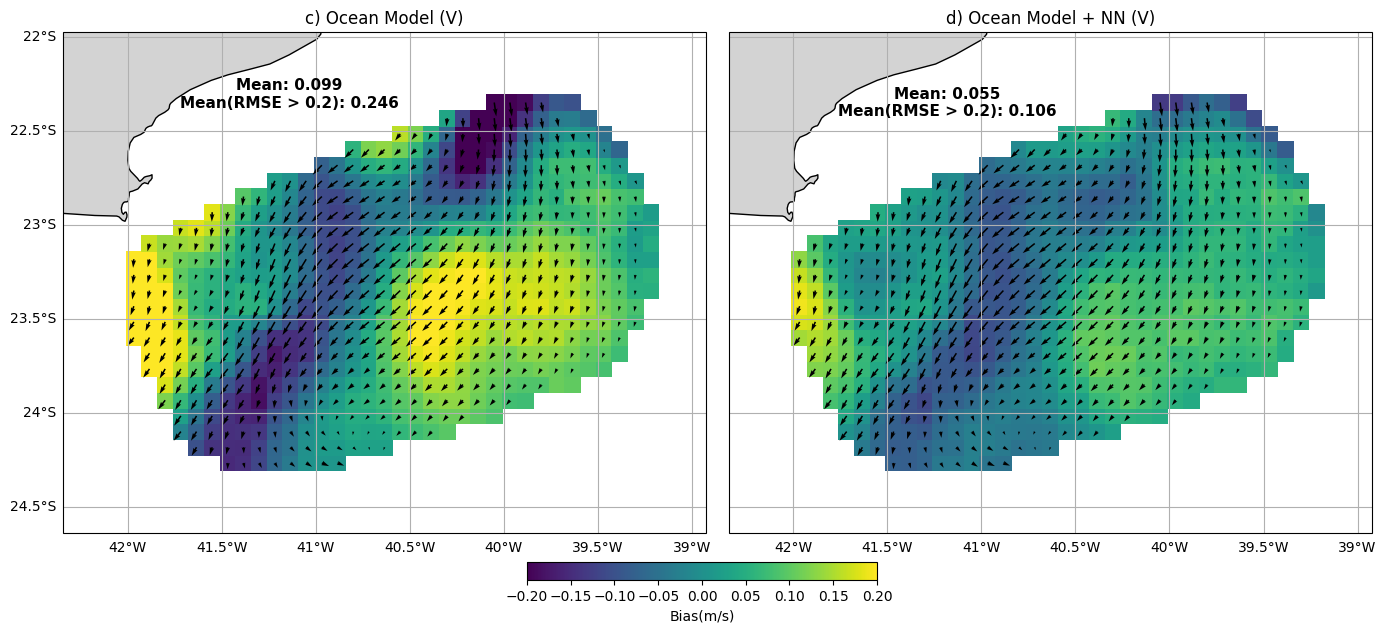

In [133]:
import numpy as np
import matplotlib.pyplot as plt

# Variáveis do modelo e observado
vi = input_sequences[:, -1, :, :, -1]  # Modelo original (último tempo da sequência)
vi = input_scalerv.inverse_transform(vi.reshape(-1, 1)).reshape(vi.shape)

vs = predicted_res[:, :, :, -1]  # Correção
vs = input_scalerv.inverse_transform(vs.reshape(-1, 1)).reshape(vs.shape)

observed = output_sequences[:, :, :, -1]  # Medido (observado)

# Bias ponto a ponto ao longo do tempo
bias_original = np.nanmean(vi - observed, axis=0)  # Bias para o modelo original
bias_corrected = np.nanmean((vi + vs) - observed, axis=0)  # Bias para o modelo corrigido

# Cálculo das médias dos campos de Bias
mean_bias_original = np.nanmean(np.abs(bias_original))
mean_bias_corrected = np.nanmean(np.abs(bias_corrected))



# Exibindo as médias dos Bias
print(f"Média do Bias - Modelo Original: {mean_bias_original:.4f}")
print(f"Média do Bias - Modelo Corrigido: {mean_bias_corrected:.4f}")

# Máscara onde o Bias do modelo original é maior que 0.4 em valor absoluto
mask = np.abs(bias_original) > 0.2

# Calcular as médias usando apenas os pontos onde o Bias do modelo original > 0.4 (em valor absoluto)
mean_bias_original_masked = np.nanmean(np.abs(bias_original[mask]))
mean_bias_corrected_masked = np.nanmean(np.abs(bias_corrected[mask]))

print(f"Média do Bias - Modelo Original (|Bias| > 0.4): {mean_bias_original_masked:.4f}")
print(f"Média do Bias - Modelo Corrigido (|Bias| > 0.4): {mean_bias_corrected_masked:.4f}")
lon, lat = np.meshgrid(file.lon.values, file.lat.values)
# Visualização do Bias como campos espaciais (latitude x longitude)

fig = plt.figure(figsize=(14, 6))

# Subplot 1 - Modelo Original
ax1 = plt.subplot(1, 2, 1, projection=ccrs.PlateCarree())

#plt.title("RMSE V component")
ax1.set_title("c) Ocean Model (V)")
pc1 = ax1.pcolor(lon, lat, bias_original, cmap='viridis', vmin=-0.2, vmax=0.2, transform=ccrs.PlateCarree())
ax1.quiver(lon, lat, np.nanmean(output_sequences[:, :, :, 0], axis=0) - uc[0] * 0, np.nanmean(output_sequences[:, :, :, 1], axis=0) - uc[0] * 0)
ax1.set_xlabel("Longitude")
ax1.set_ylabel("Latitude")

# Cartopy features
ax1.coastlines()
ax1.add_feature(cfeature.BORDERS, linewidth=0.5)
ax1.add_feature(cfeature.LAND, facecolor='lightgray')
ax1.add_feature(cfeature.OCEAN, facecolor='white')
gl1 = ax1.gridlines(draw_labels=True)
gl1.linewidth = 0.2
gl1.top_labels = False
#gl1.bottom_labels = False
gl1.right_labels = False

# Subplot 2 - Modelo Corrigido
ax2 = plt.subplot(1, 2, 2, projection=ccrs.PlateCarree())

ax2.set_title("d) Ocean Model + NN (V)")
pc2 = ax2.pcolor(lon, lat, bias_corrected, cmap='viridis',vmin=-0.2, vmax=0.2, transform=ccrs.PlateCarree())
ax2.quiver(lon, lat, np.nanmean(output_sequences[:, :, :, 0], axis=0) - uc[0] * 0, np.nanmean(output_sequences[:, :, :, 1], axis=0) - uc[0] * 0)
ax2.set_xlabel("Longitude")

# Cartopy features
ax2.coastlines()
ax2.add_feature(cfeature.BORDERS, linewidth=0.5)
ax2.add_feature(cfeature.LAND, facecolor='lightgray')
ax2.add_feature(cfeature.OCEAN, facecolor='white')
gl2 = ax2.gridlines(draw_labels=True)
gl2.linewidth = 0.2
gl2.top_labels = False
#gl2.bottom_labels = False
gl2.right_labels = False
gl2.left_labels = False  # Remove para não repetir com ax1

# Colorbar horizontal
cax = fig.add_axes([0.38, 0.005, 0.25, 0.03])
cbar = fig.colorbar(pc1, cax=cax, orientation='horizontal')
cbar.set_label("Bias(m/s)")



# Texto descritivo dentro da figura
fig.text(0.21, 0.8 ,  # ajustado um pouco mais acima da colorbar
         f"Mean: {mean_bias_original:.3f}\n"
         f"Mean(RMSE > 0.2): {mean_bias_original_masked:.3f}\n",
         ha='center', va='center', fontsize=11, fontweight='bold')

fig.text(0.68, 0.8 ,  # ajustado um pouco mais acima da colorbar
         f"Mean: {mean_bias_corrected:.3f}\n"
         f"Mean(RMSE > 0.2): {mean_bias_corrected_masked:.3f}",
         ha='center', va='center', fontsize=11, fontweight='bold')


plt.tight_layout()
plt.savefig('bias_space_v.png', dpi=200, transparent=False, bbox_inches="tight")
plt.show()



In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Variáveis do modelo e observado
ui = input_sequences[:, -1, :, :, 0]  # Modelo original (último tempo da sequência)
ui = input_scaleru.inverse_transform(ui.reshape(-1, 1)).reshape(ui.shape)

us = predicted_res[:, :, :, 0]  # Correção
us = input_scaleru.inverse_transform(us.reshape(-1, 1)).reshape(us.shape)

observed = output_sequences[:, :, :, 0]  # Medido (observado)

# Bias ponto a ponto ao longo do tempo
bias_original = np.nanmean(ui - observed, axis=0)  # Bias para o modelo original
bias_corrected = np.nanmean((ui + us) - observed, axis=0)  # Bias para o modelo corrigido

# Cálculo das médias dos campos de Bias
mean_bias_original = np.nanmean(np.abs(bias_original))
mean_bias_corrected = np.nanmean(np.abs(bias_corrected))


# Exibindo as médias dos Bias
print(f"Média do Bias - Modelo Original: {mean_bias_original:.4f}")
print(f"Média do Bias - Modelo Corrigido: {mean_bias_corrected:.4f}")

# Máscara onde o Bias do modelo original é maior que 0.4 em valor absoluto
mask = np.abs(bias_original) > 0.2

# Calcular as médias usando apenas os pontos onde o Bias do modelo original > 0.4 (em valor absoluto)
mean_bias_original_masked = np.nanmean(np.abs(bias_original[mask]))
mean_bias_corrected_masked = np.nanmean(np.abs(bias_corrected[mask]))

print(f"Média do Bias - Modelo Original (|Bias| > 0.2): {mean_bias_original_masked:.4f}")
print(f"Média do Bias - Modelo Corrigido (|Bias| > 0.2): {mean_bias_corrected_masked:.4f}")
lon, lat = np.meshgrid(file.lon.values, file.lat.values)
# Visualização do Bias como campos espaciais (latitude x longitude)

fig = plt.figure(figsize=(14, 6))

# Visualização do Bias como campos espaciais (latitude x longitude)
ax1 = plt.subplot(1, 2, 1, projection=ccrs.PlateCarree())

#plt.title("RMSE V component")
ax1.set_title("a) Ocean Model (U)")
pc1 = ax1.pcolor(lon, lat, bias_original, cmap='viridis', vmin=-0.2, vmax=0.2, transform=ccrs.PlateCarree())
ax1.quiver(lon, lat, np.nanmean(output_sequences[:, :, :, 0], axis=0) - uc[0] * 0, np.nanmean(output_sequences[:, :, :, 1], axis=0) - uc[0] * 0)
ax1.set_xlabel("Longitude")
ax1.set_ylabel("Latitude")

# Cartopy features
ax1.coastlines()
ax1.add_feature(cfeature.BORDERS, linewidth=0.5)
ax1.add_feature(cfeature.LAND, facecolor='lightgray')
ax1.add_feature(cfeature.OCEAN, facecolor='white')
gl1 = ax1.gridlines(draw_labels=True)
gl1.linewidth = 0.2
gl1.top_labels = False
#gl1.bottom_labels = False
gl1.right_labels = False

# Subplot 2 - Modelo Corrigido
ax2 = plt.subplot(1, 2, 2, projection=ccrs.PlateCarree())

ax2.set_title("b) Ocean Model + NN (U)")
pc2 = ax2.pcolor(lon, lat, bias_corrected, cmap='viridis',vmin=-0.2, vmax=0.2, transform=ccrs.PlateCarree())
ax2.quiver(lon, lat, np.nanmean(output_sequences[:, :, :, 0], axis=0) - uc[0] * 0, np.nanmean(output_sequences[:, :, :, 1], axis=0) - uc[0] * 0)
ax2.set_xlabel("Longitude")

# Cartopy features
ax2.coastlines()
ax2.add_feature(cfeature.BORDERS, linewidth=0.5)
ax2.add_feature(cfeature.LAND, facecolor='lightgray')
ax2.add_feature(cfeature.OCEAN, facecolor='white')
gl2 = ax2.gridlines(draw_labels=True)
gl2.linewidth = 0.2
gl2.top_labels = False
#gl2.bottom_labels = False
gl2.right_labels = False
gl2.left_labels = False  # Remove para não repetir com ax1

# Colorbar horizontal

# Texto descritivo dentro da figura
fig.text(0.21, 0.8 ,  # ajustado um pouco mais acima da colorbar
         f"Mean: {mean_bias_original:.3f}\n"
         f"Mean(RMSE > 0.2): {mean_bias_original_masked:.3f}\n",
         ha='center', va='center', fontsize=11, fontweight='bold')

fig.text(0.68, 0.8 ,  # ajustado um pouco mais acima da colorbar
         f"Mean: {mean_bias_corrected:.3f}\n"
         f"Mean(RMSE > 0.2): {mean_bias_corrected_masked:.3f}",
         ha='center', va='center', fontsize=11, fontweight='bold')


plt.tight_layout()
plt.savefig('bias_space_u.png', dpi=200, transparent=False, bbox_inches="tight")
plt.show()


In [ ]:
plt.pcolor(np.mean(vi, axis=0)-uc[0]*0);plt.colorbar()
input_sequences.shape


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Variáveis do modelo e observado
vi = input_sequences[:, -1, :, :, 1]  # Modelo original (último tempo da sequência)
vi = input_scalerv.inverse_transform(vi.reshape(-1, 1)).reshape(vi.shape)

vs = predicted_res[:, :, :, -1]  # Correção
vs = input_scalerv.inverse_transform(vs.reshape(-1, 1)).reshape(vs.shape)

observed = output_sequences[:, :, :, -1]  # Medido (observado)

# RMSE ponto a ponto ao longo do tempo
rmse_original = np.sqrt(np.nanmean((vi - observed) ** 2, axis=0))  # RMSE para o modelo original
rmse_corrected = np.sqrt(np.nanmean(((vi + vs) - observed) ** 2, axis=0))  # RMSE para o modelo corrigido

# Cálculo das médias dos campos de RMSE
mean_rmse_original = np.nanmean(rmse_original)
mean_rmse_corrected = np.nanmean(rmse_corrected)

mask = rmse_original > 0.3

# Calcular as médias usando apenas os pontos onde o RMSE do modelo original > 0.4
mean_rmse_original_masked = np.nanmean(rmse_original[mask])
mean_rmse_corrected_masked = np.nanmean(rmse_corrected[mask])

lon, lat = np.meshgrid(file.lon.values, file.lat.values)
# Visualização do RMSE como campos espaciais (latitude x longitude)

fig = plt.figure(figsize=(14, 6))

# Subplot 1 - Modelo Original
ax1 = plt.subplot(1, 2, 1, projection=ccrs.PlateCarree())

#plt.title("RMSE V component")
ax1.set_title("c) Ocean Model (V)")
pc1 = ax1.pcolor(lon, lat, rmse_original, cmap='viridis', vmin=0, vmax=0.3, transform=ccrs.PlateCarree())
ax1.quiver(lon, lat, np.nanmean(output_sequences[:, :, :, 0], axis=0) - uc[0] * 0, np.nanmean(output_sequences[:, :, :, 1], axis=0) - uc[0] * 0)
ax1.set_xlabel("Longitude")
ax1.set_ylabel("Latitude")

# Cartopy features
ax1.coastlines()
ax1.add_feature(cfeature.BORDERS, linewidth=0.5)
ax1.add_feature(cfeature.LAND, facecolor='lightgray')
ax1.add_feature(cfeature.OCEAN, facecolor='white')
gl1 = ax1.gridlines(draw_labels=True)
gl1.linewidth = 0.2
gl1.top_labels = False
#gl1.bottom_labels = False
gl1.right_labels = False

# Subplot 2 - Modelo Corrigido
ax2 = plt.subplot(1, 2, 2, projection=ccrs.PlateCarree())

ax2.set_title("d) Ocean Model + NN (V)")
pc2 = ax2.pcolor(lon, lat, rmse_corrected, cmap='viridis', vmin=0, vmax=0.3, transform=ccrs.PlateCarree())
ax2.quiver(lon, lat, np.nanmean(output_sequences[:, :, :, 0], axis=0) - uc[0] * 0, np.nanmean(output_sequences[:, :, :, 1], axis=0) - uc[0] * 0)
ax2.set_xlabel("Longitude")

# Cartopy features
ax2.coastlines()
ax2.add_feature(cfeature.BORDERS, linewidth=0.5)
ax2.add_feature(cfeature.LAND, facecolor='lightgray')
ax2.add_feature(cfeature.OCEAN, facecolor='white')
gl2 = ax2.gridlines(draw_labels=True)
gl2.linewidth = 0.2
gl2.top_labels = False
#gl2.bottom_labels = False
gl2.right_labels = False
gl2.left_labels = False  # Remove para não repetir com ax1

# Colorbar horizontal
cax = fig.add_axes([0.38, 0.005, 0.25, 0.03])
cbar = fig.colorbar(pc1, cax=cax, orientation='horizontal')
cbar.set_label("RMSE(m/s)")

# Texto descritivo dentro da figura
fig.text(0.21, 0.8 ,  # ajustado um pouco mais acima da colorbar
         f"Mean: {mean_rmse_original:.3f}\n"
         f"Mean(RMSE > 0.3): {mean_rmse_original_masked:.3f}\n",
         ha='center', va='center', fontsize=11, fontweight='bold')

fig.text(0.68, 0.8 ,  # ajustado um pouco mais acima da colorbar
         f"Mean: {mean_rmse_corrected:.3f}\n"
         f"Mean(RMSE > 0.3): {mean_rmse_corrected_masked:.3f}",
         ha='center', va='center', fontsize=11, fontweight='bold')


plt.tight_layout()
plt.savefig('rmse_space_v.png', dpi=200, transparent=False, bbox_inches="tight")
plt.show()




<ipython-input-74-25618000d8a5>:14: RuntimeWarning: Mean of empty slice
  rmse_original = np.sqrt(np.nanmean((ui - observed) ** 2, axis=0))  # RMSE para o modelo original
<ipython-input-74-25618000d8a5>:15: RuntimeWarning: Mean of empty slice
  rmse_corrected = np.sqrt(np.nanmean(((ui + us) - observed) ** 2, axis=0))  # RMSE para o modelo corrigido
<ipython-input-74-25618000d8a5>:21: RuntimeWarning: invalid value encountered in greater
  mask = rmse_original > 0.3
<ipython-input-74-25618000d8a5>:38: RuntimeWarning: Mean of empty slice
  ax1.quiver(lon, lat, np.nanmean(output_sequences[:, :, :, 0], axis=0) - uc[0] * 0, np.nanmean(output_sequences[:, :, :, 1], axis=0) - uc[0] * 0)
<ipython-input-74-25618000d8a5>:58: RuntimeWarning: Mean of empty slice
  ax2.quiver(lon, lat, np.nanmean(output_sequences[:, :, :, 0], axis=0) - uc[0] * 0, np.nanmean(output_sequences[:, :, :, 1], axis=0) - uc[0] * 0)
/usr/local/lib/python3.10/dist-packages/cartopy/io/__init__.py:241: DownloadWarning: Download

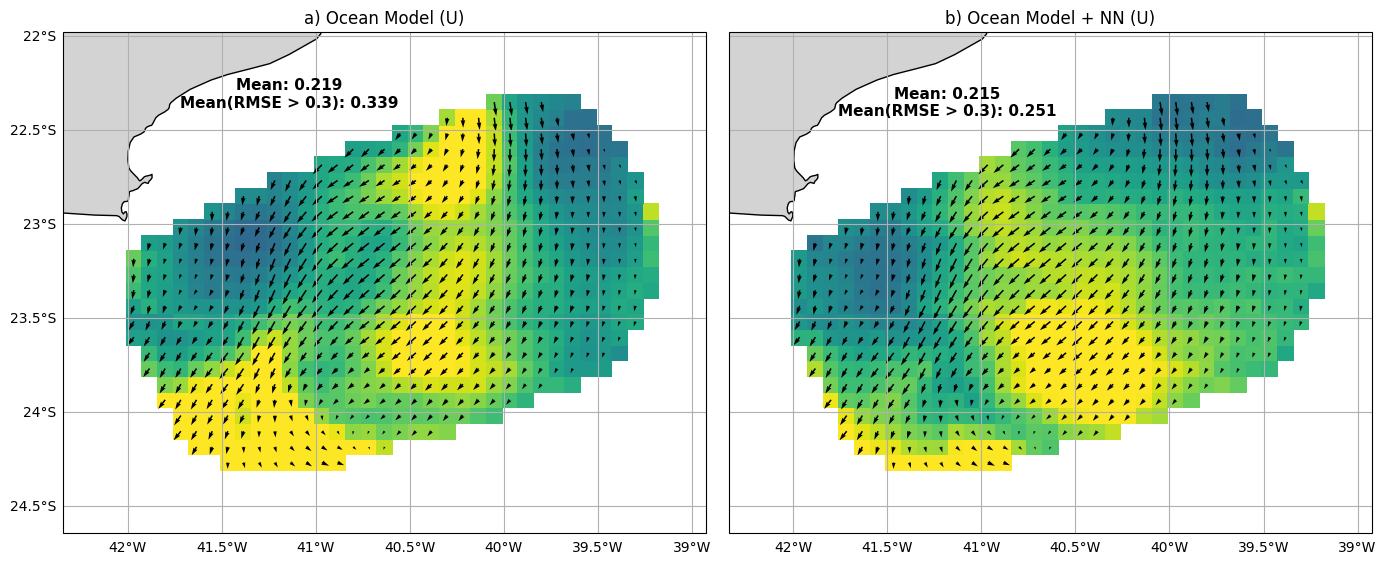

In [74]:
import numpy as np
import matplotlib.pyplot as plt

# Variáveis do modelo e observado
ui = input_sequences[:, -1, :, :, 0]  # Modelo original (último tempo da sequência)
ui = input_scaleru.inverse_transform(ui.reshape(-1, 1)).reshape(vi.shape)

us = predicted_res[:, :, :, 0]  # Correção
us = input_scaleru.inverse_transform(us.reshape(-1, 1)).reshape(vs.shape)

observed = output_sequences[:, :, :, 0]  # Medido (observado)

# RMSE ponto a ponto ao longo do tempo
rmse_original = np.sqrt(np.nanmean((ui - observed) ** 2, axis=0))  # RMSE para o modelo original
rmse_corrected = np.sqrt(np.nanmean(((ui + us) - observed) ** 2, axis=0))  # RMSE para o modelo corrigido

# Cálculo das médias dos campos de RMSE
mean_rmse_original = np.nanmean(rmse_original)
mean_rmse_corrected = np.nanmean(rmse_corrected)

mask = rmse_original > 0.3

# Calcular as médias usando apenas os pontos onde o RMSE do modelo original > 0.4
mean_rmse_original_masked = np.nanmean(rmse_original[mask])
mean_rmse_corrected_masked = np.nanmean(rmse_corrected[mask])


lon, lat = np.meshgrid(file.lon.values, file.lat.values)
# Visualização do RMSE como campos espaciais (latitude x longitude)
fig = plt.figure(figsize=(14, 6))

# Subplot 1 - Modelo Original
ax1 = plt.subplot(1, 2, 1, projection=ccrs.PlateCarree())

#plt.title("RMSE V component")
ax1.set_title("a) Ocean Model (U)")
pc1 = ax1.pcolor(lon, lat, rmse_original, cmap='viridis', vmin=0, vmax=0.3, transform=ccrs.PlateCarree())
ax1.quiver(lon, lat, np.nanmean(output_sequences[:, :, :, 0], axis=0) - uc[0] * 0, np.nanmean(output_sequences[:, :, :, 1], axis=0) - uc[0] * 0)
ax1.set_xlabel("Longitude")
ax1.set_ylabel("Latitude")

# Cartopy features
ax1.coastlines()
ax1.add_feature(cfeature.BORDERS, linewidth=0.5)
ax1.add_feature(cfeature.LAND, facecolor='lightgray')
ax1.add_feature(cfeature.OCEAN, facecolor='white')
gl1 = ax1.gridlines(draw_labels=True)
gl1.linewidth = 0.2
gl1.top_labels = False
#gl1.bottom_labels = False
gl1.right_labels = False

# Subplot 2 - Modelo Corrigido
ax2 = plt.subplot(1, 2, 2, projection=ccrs.PlateCarree())

ax2.set_title("b) Ocean Model + NN (U)")
pc2 = ax2.pcolor(lon, lat, rmse_corrected, cmap='viridis', vmin=0, vmax=0.3, transform=ccrs.PlateCarree())
ax2.quiver(lon, lat, np.nanmean(output_sequences[:, :, :, 0], axis=0) - uc[0] * 0, np.nanmean(output_sequences[:, :, :, 1], axis=0) - uc[0] * 0)
ax2.set_xlabel("Longitude")

# Cartopy features
ax2.coastlines()
ax2.add_feature(cfeature.BORDERS, linewidth=0.5)
ax2.add_feature(cfeature.LAND, facecolor='lightgray')
ax2.add_feature(cfeature.OCEAN, facecolor='white')
gl2 = ax2.gridlines(draw_labels=True)
gl2.linewidth = 0.2
gl2.top_labels = False
#gl2.bottom_labels = False
gl2.right_labels = False
gl2.left_labels = False  # Remove para não repetir com ax1

# Colorbar horizontal
#cax = fig.add_axes([0.38, 0.005, 0.25, 0.03])
#cbar = fig.colorbar(pc1, cax=cax, orientation='horizontal')
#cbar.set_label("RMSE(m/s)")

# Texto descritivo dentro da figura
# Texto descritivo dentro da figura
fig.text(0.21, 0.8 ,  # ajustado um pouco mais acima da colorbar
         f"Mean: {mean_rmse_original:.3f}\n"
         f"Mean(RMSE > 0.3): {mean_rmse_original_masked:.3f}\n",
         ha='center', va='center', fontsize=11, fontweight='bold')

fig.text(0.68, 0.8 ,  # ajustado um pouco mais acima da colorbar
         f"Mean: {mean_rmse_corrected:.3f}\n"
         f"Mean(RMSE > 0.3): {mean_rmse_corrected_masked:.3f}",
         ha='center', va='center', fontsize=11, fontweight='bold')


plt.tight_layout()
plt.savefig('rmse_space_u.png', dpi=200, transparent=False, bbox_inches="tight")
plt.show()


In [ ]:
plt.quiver(lon, lat, np.mean(ui, axis=0) - uc[0] * 0, np.mean(vi, axis=0) - uc[0] * 0)


In [ ]:
# Plotando o RMSE usando pcolor com a colormap 'viridis'
plt.pcolor(lon, lat, ((np.nanmean(output_sequences[:,:,:,0], axis=0) - uc[0] * 0)**2 +  (np.nanmean(output_sequences[:,:,:,1], axis=0) - uc[0] * 0)**2)**(1/2), vmax=1,cmap='rainbow')
plt.quiver(lon, lat, np.nanmean(output_sequences[:,:,:,0], axis=0) - uc[0] * 0, np.nanmean(output_sequences[:,:,:,1], axis=0) - uc[0] * 0)



In [ ]:
# Plotando o RMSE usando pcolor com a colormap 'viridis'
plt.pcolor(lon, lat, ((np.nanmean(ui, axis=0) - uc[0] * 0)**2 +  (np.nanmean(vi, axis=0) - uc[0] * 0)**2)**(1/2), vmax=1,cmap='rainbow')
plt.quiver(lon, lat, np.nanmean(ui, axis=0) - uc[0] * 0, np.nanmean(vi, axis=0) - uc[0] * 0)



In [ ]:
# Plotando o RMSE usando pcolor com a colormap 'viridis'
plt.pcolor(lon, lat, ((np.nanmean(ui+us, axis=0) - uc[0] * 0)**2 +  (np.nanmean(vi+vs, axis=0) - uc[0] * 0)**2)**(1/2), vmax=1,cmap='rainbow')
plt.quiver(lon, lat, np.nanmean(ui+us, axis=0) - uc[0] * 0, np.nanmean(vi+vs, axis=0) - uc[0] * 0)



<ipython-input-134-2ed04018de27>:15: RuntimeWarning: Mean of empty slice
  pc1 = ax1.pcolor(lon, lat, ((np.nanmean(output_sequences[:, :, :, 0], axis=0) - uc[0]*0)**2 +
<ipython-input-134-2ed04018de27>:16: RuntimeWarning: Mean of empty slice
  (np.nanmean(output_sequences[:, :, :, 1], axis=0) - uc[0]*0)**2)**0.5,
<ipython-input-134-2ed04018de27>:19: RuntimeWarning: Mean of empty slice
  np.nanmean(output_sequences[:, :, :, 0], axis=0) - uc[0]*0,
<ipython-input-134-2ed04018de27>:20: RuntimeWarning: Mean of empty slice
  np.nanmean(output_sequences[:, :, :, 1], axis=0) - uc[0]*0,
<ipython-input-134-2ed04018de27>:84: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0.07, 1, 1])


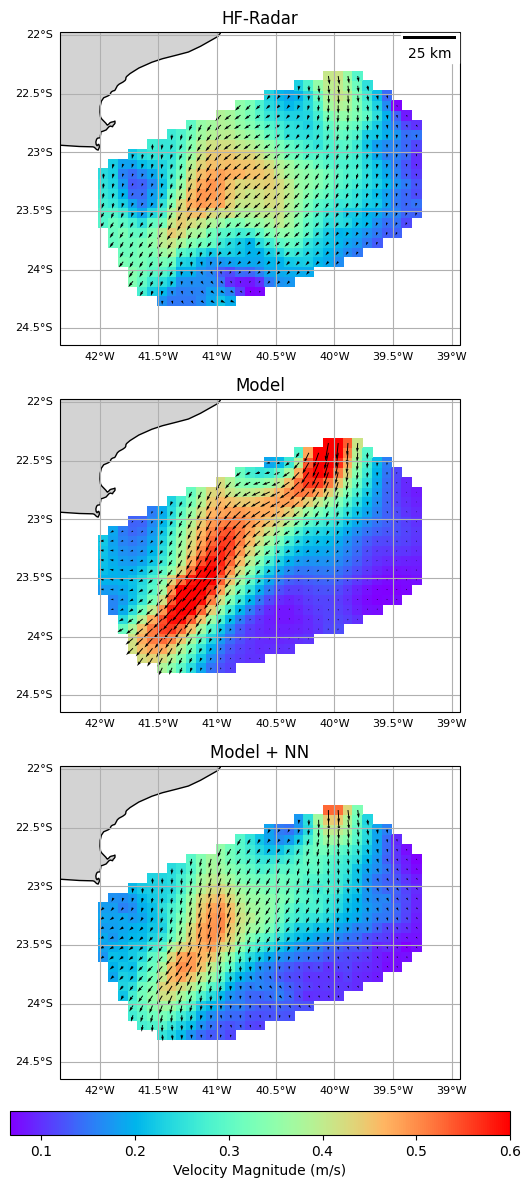

In [134]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib_scalebar.scalebar import ScaleBar
from geopy.distance import geodesic

dx = geodesic((-39.5, -22.5), (-39, -22.5)).km
scalebar = ScaleBar(dx, "km")

fig = plt.figure(figsize=(10, 12))

# Subplot 1 - HF-Radar
ax1 = plt.subplot(3, 1, 1, projection=ccrs.PlateCarree())
ax1.set_title("HF-Radar")
pc1 = ax1.pcolor(lon, lat, ((np.nanmean(output_sequences[:, :, :, 0], axis=0) - uc[0]*0)**2 +
                            (np.nanmean(output_sequences[:, :, :, 1], axis=0) - uc[0]*0)**2)**0.5,
                 vmax=0.6, cmap='rainbow', transform=ccrs.PlateCarree())
ax1.quiver(lon, lat,
           np.nanmean(output_sequences[:, :, :, 0], axis=0) - uc[0]*0,
           np.nanmean(output_sequences[:, :, :, 1], axis=0) - uc[0]*0,
           transform=ccrs.PlateCarree())
ax1.coastlines()
ax1.add_feature(cfeature.BORDERS, linewidth=0.5)
ax1.add_feature(cfeature.LAND, facecolor='lightgray')
ax1.add_feature(cfeature.OCEAN, facecolor='white')
ax1.add_artist(scalebar)
gl1 = ax1.gridlines(draw_labels=True)
gl1.top_labels = False
gl1.right_labels = False
gl1.left_labels = True
gl1.bottom_labels = True
gl1.xlabel_style = {'size': 8}
gl1.ylabel_style = {'size': 8}

# Subplot 2 - Model
ax2 = plt.subplot(3, 1, 2, projection=ccrs.PlateCarree())
ax2.set_title("Model")
pc2 = ax2.pcolor(lon, lat, ((np.nanmean(ui, axis=0) - uc[0]*0)**2 +
                            (np.nanmean(vi, axis=0) - uc[0]*0)**2)**0.5,
                 vmax=0.6, cmap='rainbow', transform=ccrs.PlateCarree())
ax2.quiver(lon, lat,
           np.nanmean(ui, axis=0) - uc[0]*0,
           np.nanmean(vi, axis=0) - uc[0]*0,
           transform=ccrs.PlateCarree())
ax2.coastlines()
ax2.add_feature(cfeature.BORDERS, linewidth=0.5)
ax2.add_feature(cfeature.LAND, facecolor='lightgray')
ax2.add_feature(cfeature.OCEAN, facecolor='white')
gl2 = ax2.gridlines(draw_labels=True)
gl2.top_labels = False
gl2.right_labels = False
gl2.left_labels = True
gl2.bottom_labels = True
gl2.xlabel_style = {'size': 8}
gl2.ylabel_style = {'size': 8}

# Subplot 3 - Model + NN
ax3 = plt.subplot(3, 1, 3, projection=ccrs.PlateCarree())
ax3.set_title("Model + NN")
pc3 = ax3.pcolor(lon, lat, ((np.nanmean(ui+us, axis=0) - uc[0]*0)**2 +
                            (np.nanmean(vi+vs, axis=0) - uc[0]*0)**2)**0.5,
                 vmax=0.6, cmap='rainbow', transform=ccrs.PlateCarree())
ax3.quiver(lon, lat,
           np.nanmean(ui+us, axis=0) - uc[0]*0,
           np.nanmean(vi+vs, axis=0) - uc[0]*0,
           transform=ccrs.PlateCarree())
ax3.coastlines()
ax3.add_feature(cfeature.BORDERS, linewidth=0.5)
ax3.add_feature(cfeature.LAND, facecolor='lightgray')
ax3.add_feature(cfeature.OCEAN, facecolor='white')
gl3 = ax3.gridlines(draw_labels=True)
gl3.top_labels = False
gl3.right_labels = False
gl3.left_labels = True
gl3.bottom_labels = True
gl3.xlabel_style = {'size': 8}
gl3.ylabel_style = {'size': 8}

# Colorbar na base
cax = fig.add_axes([0.25, 0.05, 0.5, 0.02])
cbar = fig.colorbar(pc3, cax=cax, orientation='horizontal')
cbar.set_label("Velocity Magnitude (m/s)")

plt.tight_layout(rect=[0, 0.07, 1, 1])
plt.savefig("hf_model_nn_maps.png", dpi=300, bbox_inches='tight')
plt.show()

<ipython-input-135-90456ead0bc5>:18: RuntimeWarning: Mean of empty slice
  pc1 = ax1.pcolor(lon, lat, ((np.nanmean(output_sequences[:, :, :, 0], axis=0) - uc[0]*0)**2 +
<ipython-input-135-90456ead0bc5>:19: RuntimeWarning: Mean of empty slice
  (np.nanmean(output_sequences[:, :, :, 1], axis=0) - uc[0]*0)**2)**0.5,
<ipython-input-135-90456ead0bc5>:22: RuntimeWarning: Mean of empty slice
  np.nanmean(output_sequences[:, :, :, 0], axis=0) - uc[0]*0,
<ipython-input-135-90456ead0bc5>:23: RuntimeWarning: Mean of empty slice
  np.nanmean(output_sequences[:, :, :, 1], axis=0) - uc[0]*0,


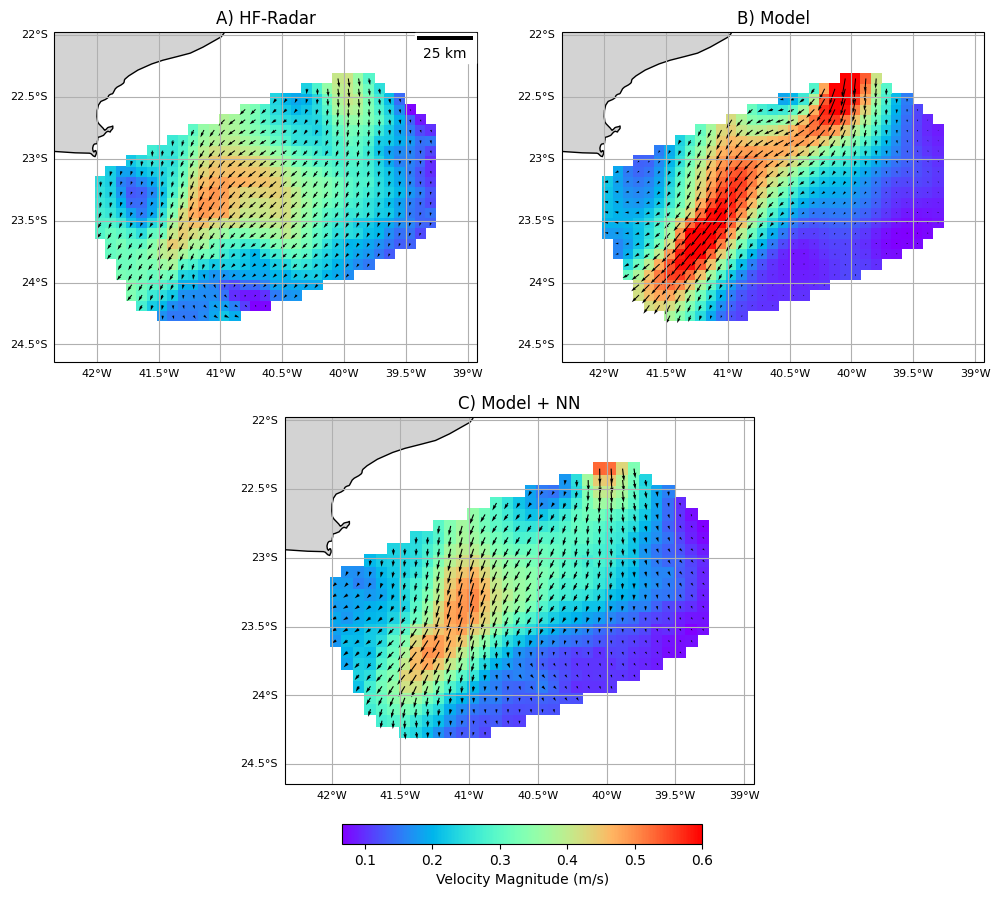

In [135]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib_scalebar.scalebar import ScaleBar
from geopy.distance import geodesic
import numpy as np  # caso não tenha importado

dx = geodesic((-39.5, -22.5), (-39, -22.5)).km
scalebar = ScaleBar(dx, "km")

fig = plt.figure(figsize=(12, 10))
gs = gridspec.GridSpec(2, 2, height_ratios=[1, 1], width_ratios=[1, 1], hspace=0.1, wspace=0.2)

# Subplot 1 - HF-Radar (em cima à esquerda)
ax1 = fig.add_subplot(gs[0, 0], projection=ccrs.PlateCarree())
ax1.set_title("A) HF-Radar")
pc1 = ax1.pcolor(lon, lat, ((np.nanmean(output_sequences[:, :, :, 0], axis=0) - uc[0]*0)**2 +
                            (np.nanmean(output_sequences[:, :, :, 1], axis=0) - uc[0]*0)**2)**0.5,
                 vmax=0.6, cmap='rainbow', transform=ccrs.PlateCarree())
ax1.quiver(lon, lat,
           np.nanmean(output_sequences[:, :, :, 0], axis=0) - uc[0]*0,
           np.nanmean(output_sequences[:, :, :, 1], axis=0) - uc[0]*0,
           transform=ccrs.PlateCarree())
ax1.coastlines()
ax1.add_feature(cfeature.BORDERS, linewidth=0.5)
ax1.add_feature(cfeature.LAND, facecolor='lightgray')
ax1.add_feature(cfeature.OCEAN, facecolor='white')
ax1.add_artist(scalebar)
gl1 = ax1.gridlines(draw_labels=True)
gl1.top_labels = False
gl1.right_labels = False
gl1.left_labels = True
gl1.bottom_labels = True
gl1.xlabel_style = {'size': 8}
gl1.ylabel_style = {'size': 8}

# Subplot 2 - Model (em cima à direita)
ax2 = fig.add_subplot(gs[0, 1], projection=ccrs.PlateCarree())
ax2.set_title("B) Model")
pc2 = ax2.pcolor(lon, lat, ((np.nanmean(ui, axis=0) - uc[0]*0)**2 +
                            (np.nanmean(vi, axis=0) - uc[0]*0)**2)**0.5,
                 vmax=0.6, cmap='rainbow', transform=ccrs.PlateCarree())
ax2.quiver(lon, lat,
           np.nanmean(ui, axis=0) - uc[0]*0,
           np.nanmean(vi, axis=0) - uc[0]*0,
           transform=ccrs.PlateCarree())
ax2.coastlines()
ax2.add_feature(cfeature.BORDERS, linewidth=0.5)
ax2.add_feature(cfeature.LAND, facecolor='lightgray')
ax2.add_feature(cfeature.OCEAN, facecolor='white')
gl2 = ax2.gridlines(draw_labels=True)
gl2.top_labels = False
gl2.right_labels = False
gl2.left_labels = True
gl2.bottom_labels = True
gl2.xlabel_style = {'size': 8}
gl2.ylabel_style = {'size': 8}

# Subplot 3 - Model + NN (embaixo, ocupando as duas colunas)
ax3 = fig.add_subplot(gs[1, :], projection=ccrs.PlateCarree())
ax3.set_title("C) Model + NN")
pc3 = ax3.pcolor(lon, lat, ((np.nanmean(ui+us, axis=0) - uc[0]*0)**2 +
                            (np.nanmean(vi+vs, axis=0) - uc[0]*0)**2)**0.5,
                 vmax=0.6, cmap='rainbow', transform=ccrs.PlateCarree())
ax3.quiver(lon, lat,
           np.nanmean(ui+us, axis=0) - uc[0]*0,
           np.nanmean(vi+vs, axis=0) - uc[0]*0,
           transform=ccrs.PlateCarree())
ax3.coastlines()
ax3.add_feature(cfeature.BORDERS, linewidth=0.5)
ax3.add_feature(cfeature.LAND, facecolor='lightgray')
ax3.add_feature(cfeature.OCEAN, facecolor='white')
gl3 = ax3.gridlines(draw_labels=True)
gl3.top_labels = False
gl3.right_labels = False
gl3.left_labels = True
gl3.bottom_labels = True
gl3.xlabel_style = {'size': 8}
gl3.ylabel_style = {'size': 8}

# Colorbar na base
cax = fig.add_axes([0.365, 0.05, 0.3, 0.02])
cbar = fig.colorbar(pc3, cax=cax, orientation='horizontal')
cbar.set_label("Velocity Magnitude (m/s)")

plt.savefig("hf_model_nn_maps_layout.png", dpi=300, bbox_inches='tight')
plt.show()


<ipython-input-137-2e6ce01e5776>:18: RuntimeWarning: Mean of empty slice
  pc1 = ax1.pcolor(lon, lat, ((np.nanmean(output_sequences[:, :, :, 0], axis=0) - uc[0]*0)**2 +
<ipython-input-137-2e6ce01e5776>:19: RuntimeWarning: Mean of empty slice
  (np.nanmean(output_sequences[:, :, :, 1], axis=0) - uc[0]*0)**2)**0.5,
<ipython-input-137-2e6ce01e5776>:22: RuntimeWarning: Mean of empty slice
  np.nanmean(output_sequences[:, :, :, 0], axis=0) - uc[0]*0,
<ipython-input-137-2e6ce01e5776>:23: RuntimeWarning: Mean of empty slice
  np.nanmean(output_sequences[:, :, :, 1], axis=0) - uc[0]*0,
<ipython-input-137-2e6ce01e5776>:90: RuntimeWarning: Mean of empty slice
  pc4 = ax4.pcolor(lonco, latco, ((np.nanmean(ucod[-2000:], axis=0) - uc[0]*0)**2 +
<ipython-input-137-2e6ce01e5776>:91: RuntimeWarning: Mean of empty slice
  (np.nanmean(vcod[-2000:], axis=0) - uc[0]*0)**2)**0.5,


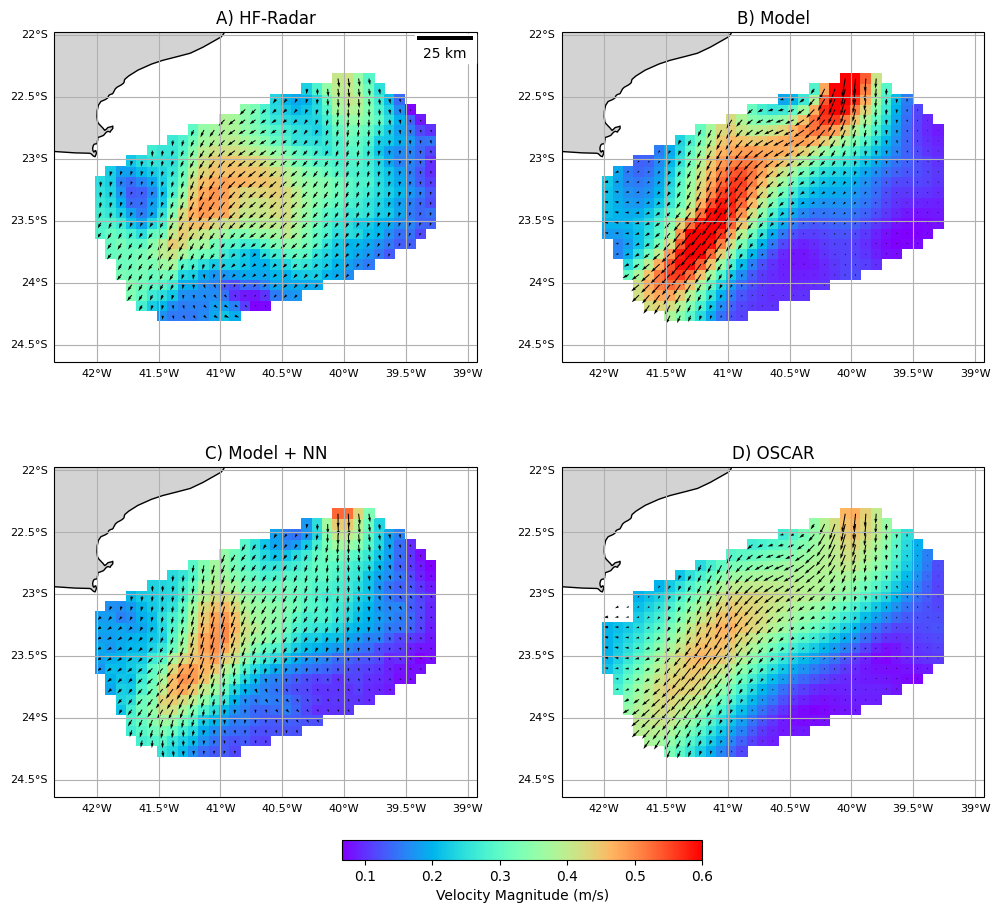

In [137]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib_scalebar.scalebar import ScaleBar
from geopy.distance import geodesic
import numpy as np

dx = geodesic((-39.5, -22.5), (-39, -22.5)).km
scalebar = ScaleBar(dx, "km")

fig = plt.figure(figsize=(12, 10))
gs = gridspec.GridSpec(2, 2, height_ratios=[1, 1], width_ratios=[1, 1], hspace=0.3, wspace=0.2)

# Subplot 1 - HF-Radar (top-left)
ax1 = fig.add_subplot(gs[0, 0], projection=ccrs.PlateCarree())
ax1.set_title("A) HF-Radar")
pc1 = ax1.pcolor(lon, lat, ((np.nanmean(output_sequences[:, :, :, 0], axis=0) - uc[0]*0)**2 +
                            (np.nanmean(output_sequences[:, :, :, 1], axis=0) - uc[0]*0)**2)**0.5,
                 vmax=0.6, cmap='rainbow', transform=ccrs.PlateCarree())
ax1.quiver(lon, lat,
           np.nanmean(output_sequences[:, :, :, 0], axis=0) - uc[0]*0,
           np.nanmean(output_sequences[:, :, :, 1], axis=0) - uc[0]*0,
           transform=ccrs.PlateCarree())
ax1.coastlines()
ax1.add_feature(cfeature.BORDERS, linewidth=0.5)
ax1.add_feature(cfeature.LAND, facecolor='lightgray')
ax1.add_feature(cfeature.OCEAN, facecolor='white')
ax1.add_artist(scalebar)
gl1 = ax1.gridlines(draw_labels=True)
gl1.top_labels = False
gl1.right_labels = False
gl1.left_labels = True
gl1.bottom_labels = True
gl1.xlabel_style = {'size': 8}
gl1.ylabel_style = {'size': 8}

# Subplot 2 - Model (top-right)
ax2 = fig.add_subplot(gs[0, 1], projection=ccrs.PlateCarree())
ax2.set_title("B) Model")
pc2 = ax2.pcolor(lon, lat, ((np.nanmean(ui, axis=0) - uc[0]*0)**2 +
                            (np.nanmean(vi, axis=0) - uc[0]*0)**2)**0.5,
                 vmax=0.6, cmap='rainbow', transform=ccrs.PlateCarree())
ax2.quiver(lon, lat,
           np.nanmean(ui, axis=0) - uc[0]*0,
           np.nanmean(vi, axis=0) - uc[0]*0,
           transform=ccrs.PlateCarree())
ax2.coastlines()
ax2.add_feature(cfeature.BORDERS, linewidth=0.5)
ax2.add_feature(cfeature.LAND, facecolor='lightgray')
ax2.add_feature(cfeature.OCEAN, facecolor='white')
gl2 = ax2.gridlines(draw_labels=True)
gl2.top_labels = False
gl2.right_labels = False
gl2.left_labels = True
gl2.bottom_labels = True
gl2.xlabel_style = {'size': 8}
gl2.ylabel_style = {'size': 8}

# Subplot 3 - Model + NN (bottom-left)
ax3 = fig.add_subplot(gs[1, 0], projection=ccrs.PlateCarree())
ax3.set_title("C) Model + NN")
pc3 = ax3.pcolor(lon, lat, ((np.nanmean(ui+us, axis=0) - uc[0]*0)**2 +
                            (np.nanmean(vi+vs, axis=0) - uc[0]*0)**2)**0.5,
                 vmax=0.6, cmap='rainbow', transform=ccrs.PlateCarree())
ax3.quiver(lon, lat,
           np.nanmean(ui+us, axis=0) - uc[0]*0,
           np.nanmean(vi+vs, axis=0) - uc[0]*0,
           transform=ccrs.PlateCarree())
ax3.coastlines()
ax3.add_feature(cfeature.BORDERS, linewidth=0.5)
ax3.add_feature(cfeature.LAND, facecolor='lightgray')
ax3.add_feature(cfeature.OCEAN, facecolor='white')
gl3 = ax3.gridlines(draw_labels=True)
gl3.top_labels = False
gl3.right_labels = False
gl3.left_labels = True
gl3.bottom_labels = True
gl3.xlabel_style = {'size': 8}
gl3.ylabel_style = {'size': 8}


lonco, latco=np.meshgrid(filecodar.lon, filecodar.lat)
ucod=filecodar.u.values
vcod =filecodar.v.values

# Subplot 4 - Repetindo Model (bottom-right)
ax4 = fig.add_subplot(gs[1, 1], projection=ccrs.PlateCarree())
ax4.set_title("D) OSCAR")
pc4 = ax4.pcolor(lonco, latco, ((np.nanmean(ucod[-2000:], axis=0) - uc[0]*0)**2 +
                            (np.nanmean(vcod[-2000:], axis=0) - uc[0]*0)**2)**0.5,
                 vmax=0.6, cmap='rainbow', transform=ccrs.PlateCarree())
ax4.quiver(lon, lat,
           np.nanmean(ui, axis=0) - uc[0]*0,
           np.nanmean(vi, axis=0) - uc[0]*0,
           transform=ccrs.PlateCarree())
ax4.coastlines()
ax4.add_feature(cfeature.BORDERS, linewidth=0.5)
ax4.add_feature(cfeature.LAND, facecolor='lightgray')
ax4.add_feature(cfeature.OCEAN, facecolor='white')
gl4 = ax4.gridlines(draw_labels=True)
gl4.top_labels = False
gl4.right_labels = False
gl4.left_labels = True
gl4.bottom_labels = True
gl4.xlabel_style = {'size': 8}
gl4.ylabel_style = {'size': 8}

# Colorbar na base (pode usar o mesmo que o subplot 3)
cax = fig.add_axes([0.365, 0.05, 0.3, 0.02])
cbar = fig.colorbar(pc3, cax=cax, orientation='horizontal')
cbar.set_label("Velocity Magnitude (m/s)")

plt.savefig("hf_model_nn_maps_2x2.png", dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
np.nanmin(ucm)

In [ ]:

mask = rmse_original > 0.1

# Calcular as médias usando apenas os pontos onde o RMSE do modelo original > 0.4
mean_rmse_original_masked = np.nanmean(rmse_original[mask])
mean_rmse_corrected_masked = np.nanmean(rmse_corrected[mask])

print(f"Média do RMSE - Modelo Original (RMSE > 0.4): {mean_rmse_original_masked:.4f}")
print(f"Média do RMSE - Modelo Corrigido (RMSE > 0.4): {mean_rmse_corrected_masked:.4f}")

In [ ]:
i=np.where(np.nanmean(u, axis=(1,2))>0.4)

print(np.mean(np.nanmean(u, axis=(1,2))[i]))
print(np.mean(np.nanmean(u2, axis=(1,2))[i]))
#print(np.nanmean(u));   print(np.nanmean(u2))

In [ ]:
id=-1950

vi=input_sequences[:,-1,:,:,-1]
vi=input_scalerv.inverse_transform(vi.reshape(-1,1)).reshape([vi.shape[0],vi.shape[1], vi.shape[2]])

ui=input_sequences[:,-1,:,:,0]
ui=input_scaleru.inverse_transform(ui.reshape(-1,1)).reshape([vi.shape[0],vi.shape[1], vi.shape[2]])


index = np.where(np.isnan(output_sequences[id, :, :, -1]))

# Criar uma cópia para não modificar o array original (opcional)
modified_input = vi.copy()

# Substituir os valores em input_sequences[id, -1, :, :, 0] pelos NaN nos índices especificados
vi[id, index[0], index[1]] = np.nan
ui[id, index[0], index[1]] = np.nan

# Plotar os vetores
plt.quiver(
    ui[id],  # Usando o array modificado
    vi[id],
    color='red',
    label='Model'
)
plt.quiver(
    output_sequences[id, :, :, 0],
    output_sequences[id, :, :, -1],
    color='black',
    label='Real'

)


# Adicionar legenda e exibir
plt.legend()
plt.show()

In [ ]:
#id=-1900

vi=input_sequences[:,-1,:,:,-1]
vi=input_scalerv.inverse_transform(vi.reshape(-1,1)).reshape([vi.shape[0],vi.shape[1], vi.shape[2]])

ui=input_sequences[:,-1,:,:,0]
ui=input_scaleru.inverse_transform(ui.reshape(-1,1)).reshape([vi.shape[0],vi.shape[1], vi.shape[2]])


index = np.where(np.isnan(output_sequences[id, :, :, -1]))

# Criar uma cópia para não modificar o array original (opcional)
modified_input = vi.copy()

# Substituir os valores em input_sequences[id, -1, :, :, 0] pelos NaN nos índices especificados
vi[id, index[0], index[1]] = np.nan
ui[id, index[0], index[1]] = np.nan



vs=predicted_res[:,:,:,-1]
vs=input_scalerrv.inverse_transform(vs.reshape(-1,1)).reshape([vi.shape[0],vi.shape[1], vi.shape[2]])

vu=predicted_res[:,:,:,0]
vu=input_scalerru.inverse_transform(vu.reshape(-1,1)).reshape([vi.shape[0],vi.shape[1], vi.shape[2]])


# Plotar os vetores
plt.quiver(
    ui[id] + vu[id, :, :],  # Usando o array modificado
    vi[id] + vs[id, :, :],
    color='red',
    label='Model'
)
plt.quiver(
    output_sequences[id, :, :, 0] ,
    output_sequences[id, :, :, -1],
    color='black',
    label='Real'

)

# Adicionar legenda e exibir
plt.legend()
plt.show()


In [ ]:
input_sequences[id,-1,:,:,1]+predicted_res[id,:,:,1]

In [ ]:
id=-1800
plt.pcolor(u[id], vmax=0.4, vmin=-0.4);plt.colorbar()

In [ ]:
plt.pcolor(u2[id], vmax=0.4, vmin=-0.4);plt.colorbar()

In [ ]:
plt.pcolor(u2[id], vmax=0.4, vmin=-0.4);plt.colorbar()

In [ ]:
vi=input_sequences[:,-1,:,:,0]

vi=input_scaleru.inverse_transform(vi.reshape(-1,1)).reshape([vi.shape[0],vi.shape[1], vi.shape[2]])

vs=predicted_res[:,:,:,0]
vs=input_scalerru.inverse_transform(vs.reshape(-1,1)).reshape([vi.shape[0],vi.shape[1], vi.shape[2]])


u=np.abs(vi - output_sequences[:,:,:,0])
u2=np.abs((vi+vs) - output_sequences[:,:,:,0])
plt.plot(np.nanmean(u, axis=(1,2)), label="Model Original")
plt.plot(np.nanmean(u2, axis=(1,2)),  label="Model corrected")
# Adicionar legenda e exibir
plt.legend()
plt.show()

In [ ]:
i=np.where(np.nanmean(u, axis=(1,2))>0.2)

print(np.mean(np.nanmean(u, axis=(1,2))[i]))
print(np.mean(np.nanmean(u2, axis=(1,2))[i]))
#print(np.nanmean(u));   print(np.nanmean(u2))